In [14]:
import pandas as pd
from difflib import SequenceMatcher, get_close_matches
import json, glob, re, time, ast # Para evaluar la string como diccionarios
from urllib import parse , request
from datetime import datetime
import numpy as np
from IPython.display import HTML, display, Image
import tabulate
import re, sqlite3

Otro error, Goñi, Florida, no lo encuentra dentro de la API de INE

A mejorar: tomar en cuenta entrada 502 (badgate way)

Comentarios sobre 

<li>Hay calles que aparecen como "calle 4" y otras donde solo aparece 4</li>

In [15]:
path = './data/Nomenclator_calles.csv'
path_prueba_IDE = './data/direcciones_codificadas.csv'
path_prueba_SIAAS = './data/montevideo.csv'
path_base_INE_corregida = './data/Direcciones_INE_codigo_corregido.csv'
errores_INE = './erroresINE/'
#base_INE = './data/direcciones_INE.csv'
#localidades_INE = './data/localidades_INE.csv'
codificador = pd.read_csv(path)

####  Requisitos y directrices sobre los componentes

<li>Padrón: Se compone de tres elementos separados entre ellos por
una barra (/). El primer elemento contiene un número de 7 dígitos
el cual indica el número del padrón. El segundo componente,
cuando existe, refiere a el Bloque el cual se indica mediante letras
mayúsculas (tres caracteres). Por último se señala la unidad
representada por dos letras (SS, EP, si es subsuelo o entrepiso,
respectivamente) y luego números naturales de cuatro dígitos</li>
<li>El nombre de la vialidad se debe
escribir en letras mayúsculas, sin siglas ni abreviaciones (a menos
que se establezca lo contrario en el documento oficial que asigna
el nombre), existiendo entre cada palabra como separador un
espacio en blanco. Cuando el nombre de la vialidad tenga un
número, éste se representa con números arábigos, por ejemplo 18
DE JULIO, CABILDO DE 1815</li>

<li>Letra de puerta: Se debe indicar mediante letras mayúsculas</li>
<li>Nombre del Inmueble: El nombre del inmueble se debe escribir
mediante caracteres alfanuméricos en mayúscula.</li>
<li>Bloque: Deben emplearse las disposiciones catastrales para
identificar el Bloque. Se debe indicar mediante número o letra y
en caso de ser este último se debe emplear letras mayúsculas.</li>
<li>Unidad: Deben emplearse las disposiciones catastrales para
identificar la Unidad.</li>
<li>Torre: Se debe especificar el nombre o número que identifica la
Torre mediante caracteres alfanuméricos en mayúscula.</li>
<li>Barrio: El nombre del barrio se debe escribir con letras
mayúsculas sin siglas ni abreviaciones.</li>
<li>Criterio de geocodificación: Debe primar como criterio
emplear el Tipo 0: Punto de Acceso</li>

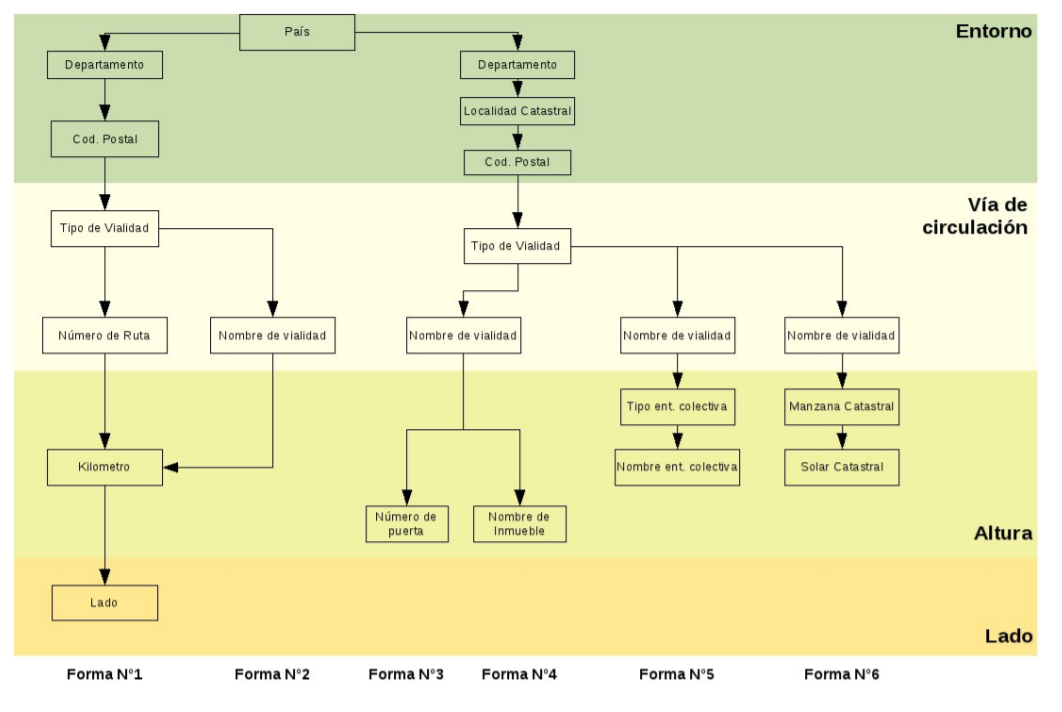

In [16]:
Image("formas_canonicas.png")

<center><h4>Formas canonicas de direcciones</h4></center>

Para el nomeclator. evitar ingresar calle "sin nombre".  Los nombres de las calles que contienen un numero debe de ser en digito

Notas. El principal problema que estoy encontrando es que las calles dentro mismo del nomenclator de INE se encuentran duplicadadas. Un 19% del dataset son entradas con idcalle duplicado. Puede ser que sean la misma calle que continua en otra localidad, ej: avenidad de las instrucciones que comunica toledo chico y montevideo. 
Un 6.5 % de las calles son duplicadas 721 nombres que generan 1888, es decir, se encuentran en la misma localidad y departamento y tienen el mismo nombre. Algunas son calles reales, ej: Progreso tiene 2 calles "Los Olivos" en distintas puntas del pueblo. Montevideo tiene 2 calles "Treinta y tres" (9231, 18853). Otras parecen ser errores de ingresado, ej: 'MACIEL, FRANCISCO ANTOÑO' en tacuarembo aparece con dos id distintos pero es la misma calle. La calle CLITERMNESTRA tiene 3 id distintas en 3 localidades diferentes (2 por cada localidad) lo que generan 6 anotaciones. 

Tambien encontre calles que faltan tanto en el nomenclator de INE como en la API, por ejemplo, 'CARLOS TIZZE' en AIGUA. 

Los calles con nombre de fecha tienen criterios distintos, ejemplo dieciocho de julio, ocho de octubre,veintiuno de setiembre, veinticeis de marzo Vs. 12 DE FEBRERO, 17 DE FEBRERO, ETC. OPCION: ADECUAR EL CODIFICADOR A UN FORMATO UNICO DE FECHAS, QUIZAS LLEVARLAS A NOMBRE?

HAY CALLES EN EL NOMENCLATOR Y API CON NUMERO ESCRITO TEXTUAL 'UNO', 'TRES' Y CON DIGITO '2', '4'

Como se definen dos secuencias iguales. Hablar de SequenceMatcher. El cutoff es de 0.6

#### Ejemplos de calles con errores para documentacion

<li>Calle Diecisiete metros de montevideo no aparece en la API si en nomenclator</li>


In [17]:
def alphanumerical_to_digit(street):
    "Checks if a number is in alphanumerical representation and changes to digits"

    str_to_number = {'PRIMERO':1,
                      'SEGUNDO':2,
                      'TRES':3,
                      'CUATRO':4,
                      'CINCO':5,
                      'SEIS':6,
                      'SIETE':7,
                      'OCHO':8,
                      'NUEVE':9,
                      'DIEZ':10,
                      'ONCE':11,
                      'DOCE':12,
                      'TRECE':13,
                      'CATORCE':14,
                      'QUINCE':15,
                      'DIECISEIS':16,
                      'DIECISIETE':17,
                      'DIECIOCHO':18,
                      'DIECINUEVE':19,
                      'VEINTE':20,
                      'VEINTIUNO':21,
                      'VEINTIDOS':22,
                      'VEINTITRES':23,
                      'VEINTICUATRO':24,
                      'VEINTICINCO':25,
                      'VEINTISEIS':26,
                      'VEINTISIETE':27,
                      'VEINTIOCHO':28,
                      'VEINTINUEVE':29,
                      'TREINTA':30,
                      'TREINTA Y UNO':31
                     }
    
    
    number = list(set(str_to_number.keys())&set(street.split()))
    
    if number:
        number = number[0]
        return street.replace(number,str(str_to_number.get(number)))
    else:
        return street

In [18]:
def digit_to_alphanumerical(street):
    "Checks if a number is in digits representation and changes to alphanumerical"
    
    number_to_string =  {'1': 'UNO',
                         '2': 'DOS',
                         '3': 'TRES',
                         '4': 'CUATRO',
                         '5': 'CINCO',
                         '6': 'SEIS',
                         '7': 'SIETE',
                         '8': 'OCHO',
                         '9': 'NUEVE',
                         '10': 'DIEZ',
                         '11': 'ONCE',
                         '12': 'DOCE',
                         '13': 'TRECE',
                         '14': 'CATORCE',
                         '15': 'QUINCE',
                         '16': 'DIECISEIS',
                         '17': 'DIECISIETE',
                         '18': 'DIECIOCHO',
                         '19': 'DIECINUEVE',
                         '20': 'VEINTE',
                         '21': 'VEINTIUNO',
                         '22': 'VEINTIDOS',
                         '23': 'VEINTITRES',
                         '24': 'VEINTICUATRO',
                         '25': 'VEINTICINCO',
                         '26': 'VEINTISEIS',
                         '27': 'VEINTISIETE',
                         '28': 'VEINTIOCHO',
                         '29': 'VEINTINUEVE',
                         '30': 'TREINTA',
                         '31': 'TREINTA Y UNO'}
    
    digit = list(set(number_to_string.keys())&set(street.split()))
    if digit:
        return street.replace(digit[0],str(number_to_string.get(digit[0])))
        
    #if len(digit) >= 2:
    #    street = ' '.join(street.split()[:-1])
    #    digit = digit[0]
    #    return street.replace(digit,str(number_to_string.get(digit)))
    #elif digit:
    #    if len(street.split()) == 2:
    #        digit = digit[0]
    #        return street.replace(digit,str(number_to_string.get(digit)))
    #    else:
    #        return street.replace(digit,str(number_to_string.get(digit)))
    #else:
    #    return street

In [19]:
def suggest_dep(string):
    """Suggest a departamento """
    departamentos =(["artigas",
                    "canelones",
                    "cerro largo",
                    "colonia",
                    "durazno",
                    "flores",
                    "florida",
                    "lavalleja",
                    "maldonado",
                    "montevideo",
                    "paysandú",
                    "río negro",
                    "rivera",
                    "rocha",
                    "salto",
                    "san josé",
                    "soriano",
                    "tacuarembó",
                    "treinta y tres"])
    return get_close_matches(string.lower(),departamentos,n=2,cutoff=0.6)[0]


In [70]:
df = pd.read_excel('Consideraciones particulares.xlsx')
a = df[df.columns[6]].dropna().to_list()
a 

['S/N', 'SN', 'S/NOMBRE', 'S/NOMBRE.', 'CALLE S/N']

In [71]:
def process_street(street):
    """Process the street information into INE format"""
    
    
    df = pd.read_excel('Consideraciones particulares.xlsx') #Cargo informacion de las calles especiales para que modifique un usuario
    
    streets_with_digit = df[df.columns[0]].dropna().to_list()
    
    aptos = df[df.columns[2]].dropna().to_list()
    
    forbidden_char = df[df.columns[4]].dropna().to_list()
    
    unnamed_streets =  df[df.columns[6]].dropna().to_list()
    
    non_street = [999] #Codigos para marcar que no es una calle
    
    for unnamed in unnamed_streets:
        if unnamed in street[:len(unnamed)]: # Solo discrimina aquellas calles que comienzan con este caracter
            street = street.replace(unnamed,"")
            break #Asume que existe una sola vez, de forma tal de escapar a otros SN que aparezcan en la calle. 

    for apto in aptos:
        if apto in street:
            street = "".join(street.split(apto)[0])
    if street in non_street: 
        return "",""
    
    #try:
     #   street = street # Se fija si la calle contiene texto, Si es la calle es un numero lo devuelve como string
    #except: 
     #   return str(street) , "" #LA API de IDE acepta las calles con numero en formato str(numero)   str(numero) 
        
    for char in forbidden_char:
        if char == "S/N" and char in street:
            if street.split().index("S/N") == len(street.split())-1:
                street = street.replace(char,"1")
            else:
                street = street.replace(char,"")
    if set(streets_with_digit)&set(street.split()):
        try:
            street, number = digit_to_alphanumerical(street)
        except:
            None
            
    
    try:
        if street.split()[-1].isdigit() and len(street.split())>1:
            number = street.split()[-1]
            street = ' '.join(street.split()[:-1]) #### ARRREGLAR LAS CALLES Q SON SOLO NUMERO
        else:
            number = "1"
    except:
            number = "1"
    #print("SALIDA DE PROCESS STREET",street)
    return street, number

In [72]:
def suggest_streets(string,tryouts=3):
    """Sugiere calles a partir de una string"""
    query_args = {
        "entrada" : string, # La sugerencia a buscar
        "todos":False
    }
    root = 'https://direcciones.ide.uy/'
    URL = root + '/api/v0/geocode/SugerenciaCalleCompleta?'
    #r = request.Request(
    #        url=URL,
    #        data=parse.urlencode(query_args).encode('utf-8'),
    #    )
    
    while tryouts>0:
        try:
            r = request.urlopen(URL+parse.urlencode(query_args))
            data = r.read().decode('utf-8').replace('null','None')
            break
        except Exception as e:
            tryouts -= 1
            if tryouts == 0:
                return []
            time.sleep(0.5)
            
            
    if data=='[]':
        
        #print('No existe calle similar')
        return []
    else:
        return ast.literal_eval(data)

In [73]:
def suggest_location(localidad,departamento,limit=10,tryouts=3):
    """Sugiere una localidad a partir de una string y checkea contra un departamento devolviendo sugerencia e id"""

    
    departamentos =(["artigas",
                    "canelones",
                    "cerro largo",
                    "colonia",
                    "durazno",
                    "flores",
                    "florida",
                    "lavalleja",
                    "maldonado",
                    "montevideo",
                    "paysandú",
                    "río negro",
                    "rivera",
                    "rocha",
                    "salto",
                    "san josé",
                    "soriano",
                    "tacuarembó",
                    "treinta y tres"])
    
    candidato_departamento = get_close_matches(departamento.lower(),departamentos,n=limit,cutoff=0.6)[0] 
    
    string = localidad + ", "+candidato_departamento
    query_args = {
        "limit": 10,
        "q" : string, # La sugerencia a buscar
        "soloLocalidad":True
    }
    
    
    root = 'https://direcciones.ide.uy/'
    URL = root + 'api/v1/geocode/candidates?'
    while tryouts>0:
        #r = request.Request(
        #        url=URL,
        #        data=parse.urlencode(query_args).encode('utf-8'),
        #    )
        try:
            r = request.urlopen(URL+parse.urlencode(query_args))
            break
        except Exception as e:
            tryouts -= 1
            if tryouts ==0:
                return {'error':e}
            time.sleep(0.5)
    
    data = r.read().decode('utf-8')
    
    if data=='[]':
        return {'error':'No existe localidad similar'}
    else:
        data = ast.literal_eval(data.replace('null','None')) 
    try:
        localidades = [x.get('address').lower().split(',')[0] for x in data]
        idlocalidades = [x.get('idLocalidad') for x in data]
        loc_suggested = get_close_matches(localidad.lower(),localidades,n=limit,cutoff=0.6)[0] #Para localidad el matcheo queda en 0.6
        idloc_suggested = idlocalidades[localidades.index(loc_suggested)]
        return [loc_suggested , idloc_suggested]
    except Exception as e:
        #print("Este erro",e)
        loc_suggested = " "
        idloc_suggested = " "
        return [loc_suggested , idloc_suggested]

In [74]:
def search_from_API(street,loc,dep,warning=False):  #Mejorar la funcion si no tiene localidad
    """Encuentra una localidad dada una calle sugerida y una localidad. Devuelve un diccionario con los datos de esa calle"""
    
    
    
    if street and street.isdigit():
        street += " " + street # La API busca los numeros de esta forma, ej: "60 60" es una busqueda valida para la calle 60
    suggestions = suggest_streets(street)  #Consulta por calles similares a la API IDE
    
    try:
        street = str(street) #Transformo las calles de numeros en strings #transformo las 
    except Exception as e:
        return {'error':'La calle no contiene string'}
    
    street = street.strip()   #Quito los espacios en blanco
    dep = dep.strip()
    if not suggestions: #Si no se devuelven calles similares
        return  {'error':'No se encuentra calle simular'}
    
    
    streets = [x.get('calle').lower() for x in suggestions] # Hay que trabajar con lower dado que las mayusculas afectan el ratio
    suggested_loc = [x.get('localidad').lower() for x in suggestions if x.get('localidad') is not None]
    suggested_idstreet = [x.get('idCalle') for x in suggestions] 
    suggested_idloc = [x.get('idLocalidad') for x in suggestions if x.get('idLocalidad') is not None] 
    suggested_dep = [x.get('departamento').lower() for x in suggestions if x.get('departamento') is not None] 
    
    
    suggested_streets = get_close_matches(street.lower(),street,n=14,cutoff=0.6) 
    
    try:
        loc, idloc = suggest_location(loc.lower(),dep)
    except:
        return {'error':'error al sugerir localidad'}
    if not loc:
        return {'error':"no se encuentra localidad"}

    
    suggested_street_indexes = [x for x in range(len(suggested_loc)) if suggested_loc[x] == loc]
    suggested_streets = [streets[x] for x in suggested_street_indexes]
    suggested_idstreet = [suggested_idstreet[x] for x in suggested_street_indexes]
    suggested_dep =  [suggested_dep[x] for x in suggested_street_indexes]
    suggested_idloc = [suggested_idloc[x] for x in suggested_street_indexes]

    if not suggested_streets:
        return {'error':'No se encuentra calle similar'}
    
    if suggested_streets.count(suggested_streets[0])> 1:
        return {'error':'Calle Duplicada'}
    
    else:
        try:
            result = ({'calle':suggested_streets[0], #Solo se informa el primero
                   'id':suggested_idstreet[0],
                   'localidad':loc,
                   'idlocalidad':idloc,
                   'departamento':suggested_dep[0],
                   'fuente':'API INE'})
            return result
        except Exception as e:
            return {'error':e}

In [75]:
def search_from_frame(street,loc,dep,df):
    "Hace una busqueda en en cascada dep/loc/calle devolviendo un diccionario de datos"
    dep = dep.upper()    #Pasa a mayusculas ya que esta asi en el DF 
    loc = loc.upper()
    
    
    try:
        suggested_dep = get_close_matches(dep,df.departamento.unique(),n=14,cutoff=0.6)[0] #Prueba buscar el departamento
    except Exception as e:
        return {'error':'No se encuentra departamento en el frame'}
    try:
        suggested_loc = get_close_matches(loc,df[df['departamento']==suggested_dep]['localidad'].unique(),n=14,cutoff=0.8)[0]
        
    except Exception as e:
        return {'error':'No encuentro localidad en el nomenclator'} 
    
    try:
        suggested_street = get_close_matches(street,df[(df['departamento']==suggested_dep)&(df['localidad']==suggested_loc)]['calle'].unique(),n=10,cutoff=0.6)[0]
    except Exception as e:
        try: #Si la distancia de edición no funciona cuento cuantas veces aparecen los nombres de las palabras dentro de la calle en los candidatos. Quien tiene más palabras gana
            candidates = df[(df['departamento']==suggested_dep)&(df['localidad']==suggested_loc)]['calle'].unique()
            word_counts = [count_matches(street,candidate) for candidate in candidates]
            if sum(word_counts) == 0:
                return {'error': 'No se encuentra dirección ingresada'}
            suggested_street = candidates[np.argmax(word_counts)]
        except:
            return {'error': 'No se encuentra dirección ingresada'}
        
    try:
        _ , idloc = suggest_location(suggested_loc,suggested_dep,limit=10)
        if len(df[(df['departamento']==suggested_dep)&(df['calle']==suggested_street)&(df['localidad']==suggested_loc)]['idcalle']) > 1:
            return {'error':'Calle duplicada'}
        
        result = ({'calle':suggested_street , #Solo se informa el primero
                   'id': int(df[(df['departamento']==suggested_dep)&(df['calle']==suggested_street)&(df['localidad']==suggested_loc)]['idcalle']),
                   'localidad':suggested_loc,
                   'idlocalidad':idloc,
                   'departamento':suggested_dep,
                   'fuente':'Codificador'})
        return result
    except Exception as e:
        return {'error': 'No encuentro localidad en el nomenclator'}


In [76]:
def count_matches(string1,string2):
    "Cuenta cuantas veces aparecen las palabras de una calle en otra"
    return sum([string2.count(x) for x in string1.split()])

In [77]:
def get_data_IDE(street,loc,dep,df):
    """ Searchs for street data in INE API and/or INE DataFrame"""
    # HAY QUE ARREGLAR EL ULTIMO RETURN, esta en MODO DEBUG 
    
    
    
    error = ""
    # ----------
    
    special_charecters = [",","-"]
    exceptional_locs = ['PINEPARK','LAS DELICIAS',"ESTACION"]
    
    
    possible_locs = []
    
    
    # 
    if not street: #Devuelve el error si ingresa calle vacia 
        return {'error':'No se encuentra dirección ingresada'}
    
    
    #  Hay locs excepcionales que estan en el codificador y tienen -. Hay que actualizar el if
    
    for char in special_charecters: #Search for only one of this characters. 
        if set(exceptional_locs)&set(loc): #PINEPARK esta mal registrado en el Codificador de INE con un "-" no siguiendo las recomendaciones de nomenclatura
            break
        if char in loc:
            possible_locs = loc.split(char)
            break
    
    if isinstance(loc,str) :
        possible_locs.append(loc)
    else:
        possible_locs = [x.strip().upper() for x in possible_locs]
        
    if not dep:
        for loc in possible_locs:
            dep = suggest_dep(loc)
            if dep:
                possible_locs.pop(possible_locs.index(loc))
                break
                
    if street.split()[0].isdigit() and len(street.split()) > 1:
        
        for loc in possible_locs:
            result = search_from_frame(street,loc,dep,df)
            if 'error' not in result.keys():
                return result
            else:
                if not street:
                    return {'error':"No se encuentra dirección ingresada"}
                street = digit_to_alphanumerical(street)
        
    
    
    ### --------------------------------------------------------------------------
    for loc in possible_locs:
        result = search_from_API(street,loc,dep)
        if not 'error' in result.keys():
            return result
      
        else:
            if not error:
                error = ' '.join((error,result.get('error')))
            else:
                error = result.get('error')
            
            result = search_from_frame(street,loc,dep,df)
            
            if 'error' in result.keys():
                error = result.get('error')
                return {'error':error}
                #error = ' '.join((error,result.get('error')))
                #return {'error':error}
            
    return result

  ##### Esto hay que arreglarlo al final, cuando se termine el debug y agregar el error 404
    

In [78]:
def search_street(street,loc,dep,df): #VOLVER ACA A PROBAR SACANDO CALLE
    """Calls get_data_INE for data of a street. 
    If it fails it changes the street name to fix INE notation problems (mostly dates) and tries again. 
    """
    result = get_data_IDE(street,loc,dep,df)
    if 'error' in result.keys() and "CALLE" == street.split()[0]:
        street = street.replace("CALLE","")
        result = get_data_IDE(street,loc,dep,df)
    return result

Los parámetros que recibe son:
<li>•departamento (opcional): Nombre del departamento </li>
<li>•localidad (opcional): Nombre de la localidad</li>
<li>•direccion: Dirección completa. Los formatos en los que se pueden buscar direcciones son (los campos entre “[]” son opcionales):</li>
<li>•calle [número] [, localidad] [, departamento]</li>
<li>•calle [número] esquina calle2 [, localidad] [, departamento] (“esquina” también se puede escribir como “esq.” o “esq”)</li>
<li>•[calle] manzana X solar Y [, localidad] [, departamento] (manzana también se puede escribir como man. o m. y solar como sol. o s.)</li>
•nombre de inmueble [, localidad] [, departamento]</li>

In [79]:
def search_address(street,loc,dep,codificador,tryouts=3):
    """Finds a location """
    
    street = parse.unquote(street)
    
    street, number = process_street(street)
    
    #print("Entrada search address", street,number)
    
    validated_street = search_street(street,loc,dep,codificador)
    street = validated_street.get('calle')
        
    if not street or  validated_street.get("error")=='Calle duplicada':
        return ({'calleNormalizada':'',
                     'idCalleIDE':'',
                     'nro_puerta':'',
                     'codigoPostal':'',
                     'puntoX':'',
                     'puntoY':'',
                     'idPuntoIDE':'',
                     'error':validated_street.get('error')})
    
    street = street + ' ' + number + ' '
    dep = dep.upper() + ' '
    loc = loc.upper()
    
    
    #street = result.get('calle') + str(result.get('numero')) +' ' # La api de direcciones exactas Quotea los caracteres especiales y agrega un espacio al final de cada valor
    #dep = result.get("departamento") + ' '
    #loc = result.get("localidad")
    root = 'https://direcciones.ide.uy/'
    URL = root + 'api/v0/geocode/BusquedaDireccion?'
    
    query_args = {
        "calle" : street, # La sugerencia a buscar
        "departamento":dep,
        "localidad":loc
    }
    
    while tryouts>0:
        try:
            r = request.urlopen(URL+parse.urlencode(query_args,quote_via=parse.quote))
            data = r.read().decode('utf-8').replace('null','None')
            break
        except Exception as e:
            tryouts -= 1
            if tryouts == 0:
                return ({'calleNormalizada':'',
                     'idCalleIDE':'',
                     'nro_puerta':'',
                     'codigoPostal':'',
                     'puntoX':'',
                     'puntoY':'',
                     'idPuntoIDE':'',
                     'error': e + ' en API IDE'})
                
    
    result = ast.literal_eval(data)
    
    for parcial in result:
        dire = parcial.get('direccion')
        try:
            street_id = dire.get('calle').get('idCalle')
        except Exception as e:
            return ({'calleNormalizada':'',
                     'idCalleIDE':'',
                     'nro_puerta':'',
                     'codigoPostal':'',
                     'puntoX':'',
                     'puntoY':'',
                     'idPuntoIDE':'',
                     'error':'No se encuentra dirección ingresada'})

        if street_id == validated_street.get('id'):
            result = parcial
            break
        result = []
            
            
    if isinstance(result, list):
        return ({'calleNormalizada':'',
                     'idCalleIDE':'',
                     'nro_puerta':'',
                     'codigoPostal':'',
                     'puntoX':'',
                     'puntoY':'',
                     'idPuntoIDE':'',
                     'error':'No se encuentra dirección ingresada'})

            
    if result:
        #if 'PUNTO NO ENCONTRADO.' in result.get('error'):
        #    street += " 0" # Si falta numero de puerta hay que agregarselo por error en API IDE
        #    return search_address(street,loc,dep,codificador,tryouts=3)
        calle_nor = result.get('direccion').get('calle').get('nombre_normalizado')
        calle_id = result.get('direccion').get('calle').get('idCalle')
        nro_puerta = result.get('direccion').get('numero',{'nro_puerta':'1'}).get('nro_puerta') #Algunas entradas no tienen numero de puerta
        codigoPostal = result.get('codigoPostal')
        puntoX = result.get('puntoX')
        puntoY = result.get('puntoY')
        idPuntoIDE = result.get('idPunto')
        error = ""

        return ({'calleNormalizada':calle_nor,
                 'idCalleIDE':calle_id,
                 'nro_puerta_aprox':nro_puerta,
                 'codigoPostal':codigoPostal,
                 'puntoX':puntoX,
                 'puntoY':puntoY,
                 'idPuntoIDE':idPuntoIDE,
                 'error':error})
    
    elif street.split()[0].isdigit(): #Evita las calles '3'            
            # Algunas calles tienen nomenclatura ambigua en cuanto a los digitos en la base INE, por lo que hay que chequear. 
        street = digit_to_alphanumerical(street) 
           
        return search_address(street,loc,dep,codificador)
    else:
        return ({'calleNormalizada':'',
                     'idCalleIDE':'',
                     'nro_puerta':'',
                     'codigoPostal':'',
                     'puntoX':'',
                     'puntoY':'',
                     'idPuntoIDE':'',
                     'error':'No se encuentra dirección ingresada'})


In [80]:
def query_base():
    list_db = ('latitud',
          'longitud',
          'punto_wkb',
          'codigo_postal',
          'codigo_postal_ampliado',
          'codigo_via',
          'nombre_via',
          'num_puerta',
          'letra_puerta',
          'km',
          'manzana',
          'solar',
          'nombre_inmueble',
          'localidad',
          'codigo_localidad',
          'departamento'  
         )
    
    conn = sqlite3.connect('Codificador_prueba.sqlite') 
    cur = conn.cursor()   #-34.9133309810151 -34.91333098101629 -56.17793508431697 -56.177935084317
    
    
    puntoX =  "'" + str(dataX) + "%'" ###la longitud esta errada en la base por 2 digitos
    puntoY = "'" + str(dataY)  + "%'"  ###la longitud esta errada en la base por 3 digigos. 
    script = 'SELECT * FROM Datos WHERE longitud LIKE {} AND latitud LIKE {} AND '.format(puntoX,puntoY)
    print(script)
    cur.execute(script)
    query = cur.fetchall()
    if not query:
    #    query = query[0]
    #else:
        return 'No hay datos'
    print(len(query))
    for data in query:
        result = {}
        index = 0
        for item in data:
            value = data[index]
            if value:
                result[item] = value
            index += 1
        print(result)
    conn.close()

In [82]:
start = datetime.now()
calle = 'S/N 808' # manzana 51 solar 04    
localidad = 'montevideo' 
departamento = 'montevideo'
print("Sugerir calle dado la entrada {} en la localidad {}".format(calle,localidad))
#print(get_data_IDE(calle,localidad,departamento,codificador))
#print(search_street(calle,localidad,departamento,codificador))
print(search_address(calle,localidad,departamento,codificador))
print("El script demoro:", datetime.now() - start)

Sugerir calle dado la entrada S/N 808 en la localidad montevideo
{'calleNormalizada': '', 'idCalleIDE': '', 'nro_puerta': '', 'codigoPostal': '', 'puntoX': '', 'puntoY': '', 'idPuntoIDE': '', 'error': 'No se encuentra dirección ingresada'}
El script demoro: 0:00:00.136477


In [83]:
counter = 0
for index, row in codificador.iterrows():
    if counter % 1000 == 0:
        print("van", counter)
    calle = row['calle']
    dep = row['departamento']
    loc = row['localidad']
    calles_duplicadas = []
    id_diferentes = []
    try:
        result = search_address(calle,loc,dep,codificador)
        if result.get('error'):
            #print("ERROR EN ",calle, dep, loc)
            calles_duplicadas.append((calle,dep,loc))
        if result.get('idCalleIDE') != row['idcalle']:
            id_diferentes.append((calle,dep,loc))
            #print(calle, dep, loc,  result.get('idCalleIDE') , row['idcalle'])
    except Exception as e:
        print(e)
        print(calle, dep, loc)
    counter += 1 

van 0
van 1000
van 2000
van 3000
van 4000
van 5000
van 6000
van 7000
van 8000
van 9000
van 10000
van 11000
object of type 'int' has no len()
LUNA, GRAL. PAYSANDU PAYSANDU
object of type 'int' has no len()
F CANELONES LAS TOSCAS
object of type 'int' has no len()
F CANELONES PARQUE DEL PLATA
object of type 'int' has no len()
SORIANO CANELONES PROGRESO
object of type 'int' has no len()
GOMEZ, JUAN TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ARENA, DOMINGO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
DE SANTANDREU, PAUL TACUAREMBO TACUAREMBO
object of type 'int' has no len()
PALOMEQUE, HERMENEGILDO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
2 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
2 CANELONES SAN JOSE DE CARRASCO
object of type 'int' has no len()
2 CANELONES COLONIA LAMAS
object of type 'int' has no len()
SANTIAGO GADEA RIVERA RIVERA
object of type 'int' has no len()
LEONEL VIERA TACUAREMBO TACUAREMBO
object of type 'int' has no l

object of type 'int' has no len()
CONT. BOLIVAR COLONIA ROSARIO
object of type 'int' has no len()
ISMAEL (CMNO.SASTRE) CANELONES BARROS BLANCOS
object of type 'int' has no len()
ISMAEL (CMNO.SASTRE) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
UTE 13 COLONIA ROSARIO
object of type 'int' has no len()
1 DE AGOSTO COLONIA OMBUES DE LAVALLE
object of type 'int' has no len()
25 DE MAYO COLONIA OMBUES DE LAVALLE
object of type 'int' has no len()
INSTRUCCIONES SAN JOSE RAFAEL PERAZZA
object of type 'int' has no len()
19 DE ABRIL COLONIA OMBUES DE LAVALLE
object of type 'int' has no len()
SUD AMERICA COLONIA CARMELO
object of type 'int' has no len()
MALLORCA CANELONES EL PINAR
object of type 'int' has no len()
Y CANELONES PARQUE DEL PLATA
object of type 'int' has no len()
CERRO CATERAL MALDONADO OCEAN PARK
object of type 'int' has no len()
VARELA, JOSE PEDRO TACUAREMBO SAN GREGORIO DE POLANCO
object of type 'int' has no len()
Z  3 CANELONES PARQUE DEL PLATA
object of typ

object of type 'int' has no len()
18 DE JULIO PAYSANDU LORENZO GEYRES
object of type 'int' has no len()
VARELA, JOSE PEDRO PAYSANDU LORENZO GEYRES
object of type 'int' has no len()
17  (BARRIO VILLALBA) PAYSANDU LORENZO GEYRES
object of type 'int' has no len()
CERRO LARGO ARTIGAS BELLA UNION
object of type 'int' has no len()
OFICIAL ONCE ARTIGAS BELLA UNION
object of type 'int' has no len()
AYUI RIVERA RIVERA
object of type 'int' has no len()
AYUI RIVERA LAGUNON
object of type 'int' has no len()
LUSSICH, ANTONIO MALDONADO PUNTA BALLENA
object of type 'int' has no len()
LUSSICH, ANTONIO MALDONADO LOS CORCHOS
object of type 'int' has no len()
GONZALEZ MIERES; LEANDRO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
MAZZONI MALDONADO MALDONADO
object of type 'int' has no len()
MAZZONI MALDONADO CERRO PELADO
object of type 'int' has no len()
D CANELONES PINAMAR
object of type 'int' has no len()
D CANELONES PINAMAR - PINEPARK
object of type 'int' has no len()
34 CANELONES ATLANTIDA
o

object of type 'int' has no len()
33 ORIENTALES RIVERA RIVERA
object of type 'int' has no len()
LAS PIEDRAS CANELONES EL PINAR
object of type 'int' has no len()
44 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
44 CANELONES SOLYMAR
object of type 'int' has no len()
LARRAÑAGA, DAMASO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
LARRAÑAGA, DAMASO CANELONES SAN JOSE DE CARRASCO
object of type 'int' has no len()
DEL PILAR CERRO LARGO MELO
object of type 'int' has no len()
IBIRAPITA CANELONES NEPTUNIA
object of type 'int' has no len()
GENERAL JOSE GERVASIO ARTIGAS CERRO LARGO MELO
object of type 'int' has no len()
REMIGIO CASTELLANOS CERRO LARGO MELO
object of type 'int' has no len()
BENITO NARDONE RIVERA RIVERA
object of type 'int' has no len()
COLON FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
COLON LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
URUGUAY COLONIA NUEVA HELVECIA
object of type 'int' has no len()
FLORIDA 

object of type 'int' has no len()
CALLEROS RIVERA RIVERA
object of type 'int' has no len()
UTE 18 (AS. 6) MALDONADO MALDONADO
object of type 'int' has no len()
VENEZUELA SORIANO CAÑADA NIETO
object of type 'int' has no len()
PERU SORIANO CAÑADA NIETO
object of type 'int' has no len()
1 SORIANO PALO SOLO
object of type 'int' has no len()
1 SORIANO CAÑADA NIETO
object of type 'int' has no len()
ZAENZ, C. SORIANO PALMITAS
object of type 'int' has no len()
DE IBARBOUROU, JUANA SORIANO PALMITAS
object of type 'int' has no len()
ALONZO Y TRELLES, J. MALDONADO SAUCE DE PORTEZUELO
object of type 'int' has no len()
RODRIGUEZ SERRANO, JUAN SORIANO PALMITAS
object of type 'int' has no len()
JAUREGUI, LAUREANA SORIANO PALMITAS
object of type 'int' has no len()
PERUCHENA, JOSE SORIANO PALMITAS
object of type 'int' has no len()
REYLES, CARLOS SORIANO PALMITAS
object of type 'int' has no len()
A ALMACEN LEITE RIVERA PASO LAPUENTE
object of type 'int' has no len()
MARTE CANELONES CIUDAD DE LA COSTA
ob

TENIENTES DE ARTIGAS CANELONES LAS PIEDRAS
object of type 'int' has no len()
1 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
IBICUY SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
LOS CARDENALES CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
LOS CARDENALES CANELONES MONTES DE SOLYMAR
object of type 'int' has no len()
2 COLONIA ROSARIO
object of type 'int' has no len()
MARIN, CANDIDO SAN JOSE RAIGON
object of type 'int' has no len()
MICHELINI, ZELMAR FLORIDA FLORIDA
object of type 'int' has no len()
CIUDAD DE CANELONES CANELONES EL PINAR
object of type 'int' has no len()
TRAPANI, JACINTO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
TRAPANI, JACINTO TACUAREMBO BARRIO LOPEZ
object of type 'int' has no len()
LAVALLEJA, GRAL. FLORIDA PINTADO
object of type 'int' has no len()
8 CANELONES COLINAS DE SOLYMAR
object of type 'int' has no len()
20 MALDONADO PLAYA GRANDE
object of type 'int' has no len()
COLOMBES CANELONES CANELONES
object of type 'i

SUAREZ, JOAQUIN FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
SUAREZ, JOAQUIN LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
A CERRO LARGO FLORIDA NICO PEREZ
object of type 'int' has no len()
ANDRESITO CANELONES SAN JOSE DE CARRASCO
object of type 'int' has no len()
ANDRESITO CANELONES EMPALME NICOLICH
object of type 'int' has no len()
44 COLONIA JUAN LACAZE
object of type 'int' has no len()
TROPAS FLORIDA NICO PEREZ
object of type 'int' has no len()
TROPAS FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
TROPAS LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
SAN LUIS CANELONES PROGRESO
object of type 'int' has no len()
BERTECH, PEDRO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
BERTECH, PEDRO CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
LINEA DIVISORIA RIVERA CERRILLADA
object of type 'int' has no len()
RIO YI FLORIDA NICO PEREZ
object of type 'int' has no len()
DAYMAN FLORIDA

object of type 'int' has no len()
GUZMAN SORIANO PALMITAS
object of type 'int' has no len()
CANNES MALDONADO PIRIAPOLIS
object of type 'int' has no len()
ZORRILLA DE SAN MARTIN SORIANO PALMITAS
object of type 'int' has no len()
GABOTO SORIANO PALMITAS
object of type 'int' has no len()
MANENTE, DR.HOMERO SORIANO PALMITAS
object of type 'int' has no len()
18 DE JULIO SORIANO PALMITAS
object of type 'int' has no len()
90 (KM. 14) PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
90 (KM. 14) PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
90 (KM. 14) PAYSANDU PUEBLO ESPERANZA
object of type 'int' has no len()
LAVALLEJA SORIANO PALMITAS
object of type 'int' has no len()
FRATERNIDAD CANELONES COLONIA NICOLICH
object of type 'int' has no len()
HARRISON FLORIDA SARANDI GRANDE
object of type 'int' has no len()
16 CANELONES PARQUE DEL PLATA
object of type 'int' has no len()
BRUM, BALTASAR TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
SAN RAMON CANELONES LA

object of type 'int' has no len()
ROYOL,DR JOSE M RIVERA RIVERA
object of type 'int' has no len()
GAMBA, DR.YAMANDU TACUAREMBO SAN GREGORIO DE POLANCO
object of type 'int' has no len()
1 (PQUE.MIRAMAR) CANELONES BARRA DE CARRASCO
object of type 'int' has no len()
1 (PQUE.MIRAMAR) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
1 (PQUE.MIRAMAR) CANELONES PARQUE MIRAMAR
object of type 'int' has no len()
17 METROS (C. CARRASCO AL 53) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
17 METROS (C. CARRASCO AL 53) CANELONES PASO CARRASCO
object of type 'int' has no len()
17 METROS (C. CARRASCO AL 53) CANELONES BARRIO MONTERREY
object of type 'int' has no len()
YAPEYU PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
YAPEYU PAYSANDU PAYSANDU
object of type 'int' has no len()
YAPEYU PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
ARTIGAS TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
DURAZNO TREINTA Y TRES VILLA SARA
object of ty

object of type 'int' has no len()
PUBLICA NO.1(EL CAÑON) MALDONADO MALDONADO
object of type 'int' has no len()
PUBLICA NO.1(EL CAÑON) MALDONADO CERRO PELADO
object of type 'int' has no len()
188 LAVALLEJA MINAS
object of type 'int' has no len()
MEVIR PAYSANDU PIEDRAS COLORADAS
object of type 'int' has no len()
HARRIS, PAUL LAVALLEJA MINAS
object of type 'int' has no len()
PERU SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
NO.14 CERRO LARGO RIO BRANCO
object of type 'int' has no len()
FOSSATI, ANTONIO ROCHA CHUY
object of type 'int' has no len()
14 (KM. 1 AL 2) SORIANO MERCEDES
object of type 'int' has no len()
UTE 15 (BARRIO GOSLINO) SALTO SALTO
object of type 'int' has no len()
BRASIL CANELONES SANTA LUCIA
object of type 'int' has no len()
CMNO. CERRO PELADO MALDONADO MALDONADO
object of type 'int' has no len()
CMNO. CERRO PELADO MALDONADO CERRO PELADO
object of type 'int' has no len()
180 LAVALLEJA MINAS
object of type 'int' has no len()
PIEDRAS LAVALLEJA MINAS
object o

object of type 'int' has no len()
VARELA, OBDULIO (J.D.AMERICA) CANELONES PASO CARRASCO
object of type 'int' has no len()
VARELA, OBDULIO (J.D.AMERICA) CANELONES BARRIO MONTERREY
object of type 'int' has no len()
RECONQUISTA MALDONADO SAN CARLOS
object of type 'int' has no len()
7 FLORIDA NICO PEREZ
object of type 'int' has no len()
7 FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
7 LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
DUHART, PEDRO MALDONADO SAN CARLOS
object of type 'int' has no len()
GASTON ROSAS CANELONES CANELONES
object of type 'int' has no len()
TREINTA Y TRES, CONTINUACION MALDONADO SAN CARLOS
object of type 'int' has no len()
PURIFICACION CANELONES SAN RAMON
object of type 'int' has no len()
VIVERO CANELONES INSTITUTO ADVENTISTA
object of type 'int' has no len()
VIVERO CANELONES CANELONES
object of type 'int' has no len()
VIVERO CANELONES PARADA CABRERA
object of type 'int' has no len()
AIGUA (EX CALLE 4) MALDONADO SAN CARLOS
objec

object of type 'int' has no len()
CONT.LAVALLEJA (J.DE AMERICA) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
CONT.LAVALLEJA (J.DE AMERICA) CANELONES PASO CARRASCO
object of type 'int' has no len()
CONT.LAVALLEJA (J.DE AMERICA) CANELONES BARRIO MONTERREY
object of type 'int' has no len()
YUCUTUJA PAYSANDU PAYSANDU
object of type 'int' has no len()
5 CONTINUACION BONILLA TACUAREMBO PASO BONILLA
object of type 'int' has no len()
BALBELA, NICOLAS SALTO BELEN
object of type 'int' has no len()
TAROCO CANELONES SAUCE
object of type 'int' has no len()
44 S PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
44 S PAYSANDU PAYSANDU
object of type 'int' has no len()
44 S PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
TERU CANELONES SALINAS
object of type 'int' has no len()
VENEZUELA COLONIA NUEVA HELVECIA
object of type 'int' has no len()
13 CANELONES ARGENTINO
object of type 'int' has no len()
SAN MIGUEL CANELONES SAUCE
object of type 'int' has no len()
OR

object of type 'int' has no len()
COVADONGA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
RODO, JOSE ENRIQUE MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
LINCOLN MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
LINCOLN, ABRAHAM MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
LINCOLN, ABRAHAM MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
LARRAÑAGA, DAMASO A. CANELONES EL PINAR
object of type 'int' has no len()
AVELONA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
FRANKLIN, B. MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
OBDULIO JACINTO VARELA CANELONES LA PAZ
object of type 'int' has no len()
OBDULIO JACINTO VARELA CANELONES BARRIO COPOLA
object of type 'int' has no len()
PERLAS, DE LAS CANELONES FORTIN DE SANTA ROSA
object of type 'int' has no len()
PERLAS, DE LAS CANELONES MARINDIA
object of type 'int' has no len()
ASCHERI, DR. MALDONADO SAN CARLOS
object of type 'int' has n

object of type 'int' has no len()
DE BOURRE, MARCOS RIVERA TRANQUERAS
object of type 'int' has no len()
UTE 11 (BARRIO PUERTO SECO) CERRO LARGO RIO BRANCO
object of type 'int' has no len()
BALET, ROGER PAYSANDU PAYSANDU
object of type 'int' has no len()
42 MALDONADO LA BARRA
object of type 'int' has no len()
MISIONES 3 RIVERA RIVERA
object of type 'int' has no len()
LOS ALMENDROS MALDONADO MANANTIALES
object of type 'int' has no len()
LOS ALMENDROS MALDONADO LAGUNA BLANCA
object of type 'int' has no len()
COVIMEL  6 CERRO LARGO MELO
object of type 'int' has no len()
IRRAZABAL, DANTE ARTIGAS ARTIGAS
object of type 'int' has no len()
BOLIVAR, SIMON TACUAREMBO TACUAREMBO
object of type 'int' has no len()
 LA BALSA DURAZNO PUEBLO CENTENARIO
object of type 'int' has no len()
BRISAS DEL MAR CANELONES NEPTUNIA
object of type 'int' has no len()
11 ROCHA CAPACHO
object of type 'int' has no len()
BOLIVAR, SIMON TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
GARCIA AROCENA CANELO

232 ( RIOS, LA MATUTINA ) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
BRIGADIER GENERAL MANUEL ORIBE CERRO LARGO MELO
object of type 'int' has no len()
ROCHA MALDONADO MALDONADO
object of type 'int' has no len()
UTE 12 MALDONADO LA BARRA
object of type 'int' has no len()
18 MALDONADO LA BARRA
object of type 'int' has no len()
18 MALDONADO EL TESORO
object of type 'int' has no len()
18 DE JULIO MALDONADO MANANTIALES
object of type 'int' has no len()
ARGENTINA MALDONADO PUNTA NEGRA
object of type 'int' has no len()
CARMELO COLONIA NUEVA PALMIRA
object of type 'int' has no len()
55 CANELONES PINAMAR
object of type 'int' has no len()
55 CANELONES PINAMAR - PINEPARK
object of type 'int' has no len()
REPUBLICA ARGENTINA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
REPUBLICA ARGENTINA MALDONADO MALDONADO
object of type 'int' has no len()
REPUBLICA ARGENTINA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
ARVEJILLAS, LAS MALDONADO LAS FLORES
object 

object of type 'int' has no len()
LIBERTAD COLONIA FLORENCIO SANCHEZ
object of type 'int' has no len()
A PIUMA CERRO LARGO RIO BRANCO
object of type 'int' has no len()
ARAPEY COLONIA NUEVA PALMIRA
object of type 'int' has no len()
19 DE ABRIL TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
BRASIL CANELONES EL PINAR
object of type 'int' has no len()
PIEDRAS COLONIA JUAN LACAZE
object of type 'int' has no len()
S SAN JOSE PLAYA PASCUAL
object of type 'int' has no len()
S SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
S SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
SARANDI COLONIA NUEVA PALMIRA
object of type 'int' has no len()
CEIBO (CUMBRE DE NEPTUNIA) CANELONES NEPTUNIA
object of type 'int' has no len()
9 (CUCHILLA ALTA) CANELONES CUCHILLA ALTA
object of type 'int' has no len()
9 (CUCHILLA ALTA) CANELONES CUCHILLA ALTA Y EL GALEON
object of type 'int' has no len()
BLANQUILLO (CUMB. DE NEPTUNIA) CANELONES NEPTUNIA
object of type 'int' has no l

object of type 'int' has no len()
CARLOS CAMERA CANELONES CANELONES
object of type 'int' has no len()
JOSE ENRIQUE RODO COLONIA NUEVA HELVECIA
object of type 'int' has no len()
EUDORO MELO CANELONES CANELONES
object of type 'int' has no len()
ALFREDO ZITARROSA CANELONES LA PAZ
object of type 'int' has no len()
FRUGONI RIVERA RIVERA
object of type 'int' has no len()
REVEL, AUGUSTO COLONIA COLONIA VALDENSE
object of type 'int' has no len()
VENEZUELA CANELONES PANDO
object of type 'int' has no len()
ACUARIO MALDONADO MALDONADO
object of type 'int' has no len()
ACUARIO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
JOSE PEDRO VARELA CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
JOSE PEDRO VARELA CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
JOSE PEDRO VARELA CANELONES MONTES DE SOLYMAR
object of type 'int' has no len()
JOSE PEDRO VARELA CANELONES SOLYMAR
object of type 'int' has no len()
BISIO, AGUSTIN R. RIVERA RIVERA
object of type 'int

MARACANA COLONIA TARARIRAS
object of type 'int' has no len()
PASEO DE SAN MIGUEL COLONIA COLONIA DEL SACRAMENTO
object of type 'int' has no len()
UNION CANELONES CANELONES
object of type 'int' has no len()
17 METROS PAYSANDU PAYSANDU
object of type 'int' has no len()
CONT.ARTIGAS (J.DE AMERICA) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
CONT.ARTIGAS (J.DE AMERICA) CANELONES PASO CARRASCO
object of type 'int' has no len()
CONT.ARTIGAS (J.DE AMERICA) CANELONES BARRIO MONTERREY
object of type 'int' has no len()
B CANELONES ATLANTIDA
object of type 'int' has no len()
B CANELONES CITY GOLF
object of type 'int' has no len()
CALCAGNO, DR. DOMINGO RIO NEGRO ALGORTA
object of type 'int' has no len()
CALAFI, DIAGONAL F. SALTO SALTO
object of type 'int' has no len()
CAMELIAS, LAS MALDONADO MALDONADO
object of type 'int' has no len()
PUBLICA SALTO SALTO
object of type 'int' has no len()
LAVALLEJA SORIANO CARDONA
object of type 'int' has no len()
SALTO MALDONADO PUNTA DEL ESTE
o

HUGO CHRISTIAN COLONIA NUEVA HELVECIA
object of type 'int' has no len()
CIPRESES (PARAL. A R.102), LOS CANELONES COLONIA NICOLICH
object of type 'int' has no len()
CIPRESES (PARAL. A R.102), LOS CANELONES EMPALME NICOLICH
object of type 'int' has no len()
GIRO, PTE. FRANCISCO SALTO SALTO
object of type 'int' has no len()
ITUZAINGO RIVERA TRANQUERAS
object of type 'int' has no len()
SILVA VALDEZ, FERNAN TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
23 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
23 CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
ROSAS CANELONES INSTITUTO ADVENTISTA
object of type 'int' has no len()
ROSAS CANELONES CANELONES
object of type 'int' has no len()
ROSAS CANELONES PARADA CABRERA
object of type 'int' has no len()
VISCARDI ALVAREZ CANELONES INSTITUTO ADVENTISTA
object of type 'int' has no len()
VISCARDI ALVAREZ CANELONES PARADA CABRERA
object of type 'int' has no len()
HNO ENGELBERTO - FRANCOIS L DUC

object of type 'int' has no len()
3 RIO NEGRO SARANDI DE NAVARRO
object of type 'int' has no len()
UTE  6 CANELONES ATLANTIDA
object of type 'int' has no len()
UTE  6 CANELONES ESTACION ATLANTIDA
object of type 'int' has no len()
PIEDRA ALTA RIO NEGRO YOUNG
object of type 'int' has no len()
PUGNALINI, DOCTOR TACUAREMBO TACUAREMBO
object of type 'int' has no len()
BEDUCHANT, FERNANDO FLORIDA 25 DE AGOSTO
object of type 'int' has no len()
BATLLE CANELONES SANTA LUCIA
object of type 'int' has no len()
CARRETERA AL CHICO TORINO COLONIA CHICO TORINO
object of type 'int' has no len()
GARCIA LORCA CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
GARCIA LORCA CANELONES PASO CARRASCO
object of type 'int' has no len()
GARCIA LORCA CANELONES BARRIO MONTERREY
object of type 'int' has no len()
SORIANO CANELONES VILLA SAN JOSE
object of type 'int' has no len()
GUARUYA MALDONADO OCEAN PARK
object of type 'int' has no len()
HERNANDARIAS CERRO LARGO MELO
object of type 'int' has no len()


object of type 'int' has no len()
13 CANELONES LAS TOSCAS
object of type 'int' has no len()
BLANES, NICANOR MALDONADO MALDONADO
object of type 'int' has no len()
BLANES, NICANOR MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
COLOMBES CANELONES SANTA LUCIA
object of type 'int' has no len()
MARIA LUISA LARENA RIVERA RIVERA
object of type 'int' has no len()
MARIA LUISA LARENA RIVERA LA PEDRERA
object of type 'int' has no len()
ZORRILLA DE SAN MARTIN, JUAN SORIANO DOLORES
object of type 'int' has no len()
ELLAURI CANELONES LAS PIEDRAS
object of type 'int' has no len()
ACEVEDO DIAZ, EDUARDO RIVERA RIVERA
object of type 'int' has no len()
BRUM, BALTASAR CANELONES SANTA LUCIA
object of type 'int' has no len()
JOAQUIN D. FAJARDO RIVERA RIVERA
object of type 'int' has no len()
BRASIL, CONTINUACION CANELONES SANTA LUCIA
object of type 'int' has no len()
UTE 71 ARTIGAS ARTIGAS
object of type 'int' has no len()
PIROVANO, I. MALDONADO PIRIAPOLIS
object of type 'int' has no len()

object of type 'int' has no len()
PUERTO DE LA CANDELARIA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
38 CERRO LARGO AREVALO
object of type 'int' has no len()
MOREIRA, MARCELINO CANELONES SAN ANTONIO
object of type 'int' has no len()
LAFFERRANDERIE DE CARBALLO, A. MALDONADO MALDONADO
object of type 'int' has no len()
LAFFERRANDERIE DE CARBALLO, A. MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
UTE 17 (AS. 6) MALDONADO MALDONADO
object of type 'int' has no len()
BOGOTA MALDONADO MALDONADO
object of type 'int' has no len()
BOGOTA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
OFICIAL  8 COLONIA GIL
object of type 'int' has no len()
9(LA CHINITA) SALTO TERMAS DEL DAYMAN
object of type 'int' has no len()
ARTIGAS, GRAL. CANELONES JAUREGUIBERRY
object of type 'int' has no len()
LIBERTAD CANELONES JAUREGUIBERRY
object of type 'int' has no len()
UTE  8 CANELONES JAUREGUIBERRY
object of type 'int' has no len()
A AGUAS CORRIENTES COL

object of type 'int' has no len()
BOCA JUNIOR SAN JOSE PLAYA PASCUAL
object of type 'int' has no len()
BOCA JUNIOR SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
BOCA JUNIOR SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
1 DE MAYO COLONIA JUAN LACAZE
object of type 'int' has no len()
TORTEROLO, AUDEMAR SAN JOSE CAPURRO
object of type 'int' has no len()
RODRIGUEZ, JOSE P. SAN JOSE CUCHILLA DEL VICHADERO
object of type 'int' has no len()
RODRIGUEZ, JULIO  CONTINUACION COLONIA JUAN LACAZE
object of type 'int' has no len()
MALDONADO, FRANCISCO MALDONADO MALDONADO
object of type 'int' has no len()
BACHINI, ANTONIO SORIANO DOLORES
object of type 'int' has no len()
3 TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
CERQUEIRO, JESUS FLORIDA CARDAL
object of type 'int' has no len()
FLORIDA FLORIDA CARDAL
object of type 'int' has no len()
U  1 CANELONES PARQUE DEL PLATA
object of type 'int' has no len()
2 (SAN ISIDRO) CANELONES PANDO
object of type 'int

LINEA DIVISORIA RIVERA RIVERA
object of type 'int' has no len()
CORREA, ARTEMIO TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
24 DE OCTUBRE COLONIA CONCHILLAS
object of type 'int' has no len()
KYLE, DOCTOR COLONIA CONCHILLAS
object of type 'int' has no len()
ORIBE, 1 BDIER.GRAL. M. SAN JOSE PENINO
object of type 'int' has no len()
ORIBE, 1 BDIER.GRAL. M. SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
ORIBE, 1 BDIER.GRAL. M. SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
ORIBE, 1 BDIER.GRAL. M. SAN JOSE AUTODROMO
object of type 'int' has no len()
GRASSI, EMILIA TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
9 CANELONES PANDO
object of type 'int' has no len()
9 CANELONES JARDINES DE PANDO
object of type 'int' has no len()
OFICIAL  2 COLONIA GIL
object of type 'int' has no len()
GIL, LUIS COLONIA GIL
object of type 'int' has no len()
OFICIAL  5 COLONIA GIL
object of type 'int' has no len()
OFICIAL  7 COLONIA GIL
object of type '

object of type 'int' has no len()
DEL MEDIO CANELONES PARQUE DE SOLYMAR
object of type 'int' has no len()
RODO, JOSE E. CANELONES SAN RAMON
object of type 'int' has no len()
LOS OLIVOS (V. ELECTRON) CANELONES BARROS BLANCOS
object of type 'int' has no len()
LOS OLIVOS (V. ELECTRON) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
AIGUA SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
LAVALLEJA, GRAL. JUAN A. SAN JOSE RAIGON
object of type 'int' has no len()
RIVERA SORIANO LA LOMA
object of type 'int' has no len()
RIVERA SORIANO VILLA SORIANO
object of type 'int' has no len()
VILA, BERNABE SAN JOSE RAIGON
object of type 'int' has no len()
VARELA, JOSE P. SAN JOSE RAIGON
object of type 'int' has no len()
COLONIA COLONIA TARARIRAS
object of type 'int' has no len()
PUBLICA CANELONES LA PAZ
object of type 'int' has no len()
LAS PIEDRAS COLONIA TARARIRAS
object of type 'int' has no len()
LAS PIEDRAS COLONIA SANTA ANA
object of type 'int' has no len()
CAPITAN ANT

FRANCIA PAYSANDU PAYSANDU
object of type 'int' has no len()
UTE  7 CANELONES FORTIN DE SANTA ROSA
object of type 'int' has no len()
18 DE JULIO CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
DEPARTAMENTAL A RIVERA SALTO SAN ANTONIO
object of type 'int' has no len()
RAMBLA DEL SANDU TACUAREMBO TACUAREMBO
object of type 'int' has no len()
7 MALDONADO GARZON
object of type 'int' has no len()
3 MALDONADO GARZON
object of type 'int' has no len()
ANCHORENA, ANGELA CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
ANCHORENA, ANGELA CANELONES TOLEDO
object of type 'int' has no len()
1 MALDONADO GARZON
object of type 'int' has no len()
CHANA CANELONES BARROS BLANCOS
object of type 'int' has no len()
CHANA CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
MARGARITAS, LAS CANELONES BARROS BLANCOS
object of type 'int' has no len()
MAGARIÑOS CERVANTES CANELONES SANTA LUCIA
object of type 'int' has no len()
SANCHEZ (VILLA ISESTEL), F. CANELONES BARR

object of type 'int' has no len()
DE ARTIGAS, FRANCISCA P. CANELONES SAUCE
object of type 'int' has no len()
PEREIRA, GABRIEL ANTONIO TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
PEREIRA, GABRIEL ANTONIO TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
A ESTACION ANCAP COLONIA SARANDI CAMPANA
object of type 'int' has no len()
5 FLORIDA SARANDI GRANDE
object of type 'int' has no len()
5 CANELONES ATLANTIDA
object of type 'int' has no len()
5 CANELONES VILLA ARGENTINA
object of type 'int' has no len()
FANETTI, MAGDALENA COLONIA COLONIA MIGUELETE
object of type 'int' has no len()
RIVERA, FRUCTUOSO COLONIA COLONIA MIGUELETE
object of type 'int' has no len()
CURBELO, JUAN COLONIA COLONIA MIGUELETE
object of type 'int' has no len()
ORIBE, DIONISIO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ORIBE, DIONISIO TACUAREMBO BARRIO LOPEZ
object of type 'int' has no len()
QUINTANA, DR. JOSE COLONIA COLONIA MIGUELETE
object of type 'int' has no le

object of type 'int' has no len()
BRASIL PAYSANDU PAYSANDU
object of type 'int' has no len()
MARIO PAREJA CANELONES LAS PIEDRAS
object of type 'int' has no len()
MARIO PAREJA CANELONES LA PAZ
object of type 'int' has no len()
47 CANELONES BELLO HORIZONTE
object of type 'int' has no len()
SAN MARTIN, JUAN RIVERA TRANQUERAS
object of type 'int' has no len()
MARIA ANTONIA ALVAREZ CANELONES PROGRESO
object of type 'int' has no len()
AMERICA RIVERA TRANQUERAS
object of type 'int' has no len()
9 MALDONADO BELLA VISTA
object of type 'int' has no len()
CUAREIM CANELONES LAS PIEDRAS
object of type 'int' has no len()
RIVERA TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
JUAN P LOPEZ CANELONES LA PAZ
object of type 'int' has no len()
12 DE OCTUBRE RIVERA VICHADERO
object of type 'int' has no len()
MUNIC.RAVE (B.TIRIRICA) CERRO LARGO MELO
object of type 'int' has no len()
GERONIMO PASEYRO CERRO LARGO RIO BRANCO
object of type 'int' has no len()
EMILIO ZOLA MALDONADO PUNTA DEL ESTE


object of type 'int' has no len()
CEIBO ARTIGAS ARTIGAS
object of type 'int' has no len()
CEIBO ARTIGAS PINTADITO
object of type 'int' has no len()
18 DE JULIO CERRO LARGO PLACIDO ROSAS
object of type 'int' has no len()
6 ROCHA LASCANO
object of type 'int' has no len()
5 ROCHA LASCANO
object of type 'int' has no len()
MONTEVIDEO CANELONES LAS PIEDRAS
object of type 'int' has no len()
CANDIDA P DE VOLPI CANELONES LAS PIEDRAS
object of type 'int' has no len()
DEPARTAMENTAL COLONIA FLORENCIO SANCHEZ
object of type 'int' has no len()
DEPARTAMENTAL SORIANO CARDONA
object of type 'int' has no len()
CRISTINA DIAZ DE MENDEZ CANELONES LAS PIEDRAS
object of type 'int' has no len()
LAS ROBAINAS CANELONES PROGRESO
object of type 'int' has no len()
2 ROCHA LASCANO
object of type 'int' has no len()
DEL FONDO CANELONES LA MONTAÑESA
object of type 'int' has no len()
3 ROCHA LASCANO
object of type 'int' has no len()
ORIBE,GRAL IGNACIO CERRO LARGO MELO
object of type 'int' has no len()
VAZ FERREIRA, MA.

object of type 'int' has no len()
OSORIO, J. M. FLORIDA SARANDI GRANDE
object of type 'int' has no len()
FOMENTO CANELONES LAS PIEDRAS
object of type 'int' has no len()
15 Y R. 3 (KM. 376) PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
15 Y R. 3 (KM. 376) PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
15 Y R. 3 (KM. 376) PAYSANDU AL SUR DE ARROYO SACRA
object of type 'int' has no len()
TRUFAS CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
TRUFAS CANELONES PARQUE DE SOLYMAR
object of type 'int' has no len()
VEHIC.1 CANELONES PANDO
object of type 'int' has no len()
21 MALDONADO LA BARRA
object of type 'int' has no len()
MARQUES DE LORETO MALDONADO MALDONADO
object of type 'int' has no len()
MARQUES DE LORETO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
MAGALLANES SALTO SALTO
object of type 'int' has no len()
CORBO, JUAN P. LAVALLEJA PIRARAJA
object of type 'int' has no len()
BALESTRA, MA. RIVERA RIVERA
object of type 'int' ha

object of type 'int' has no len()
4 (BARRIO JARDIN) CANELONES ATLANTIDA
object of type 'int' has no len()
POLONIO ROCHA CASTILLOS
object of type 'int' has no len()
71 MALDONADO EL CHORRO
object of type 'int' has no len()
71 MALDONADO BUENOS AIRES
object of type 'int' has no len()
75 ROCHA PUIMAYEN
object of type 'int' has no len()
UTE 113 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
CANELONES SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
17 METROS SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
17 METROS SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
17 METROS SAN JOSE AUTODROMO
object of type 'int' has no len()
FIAT SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
FIAT SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
FIAT SAN JOSE AUTODROMO
object of type 'int' has no len()
TERESA MUÑOZ CANELONES LA PAZ
object of type 'int' has no len()
CARDOZO, EDUARDO SORIANO DOLORES
object of type 'int' has no len()
4 TAC

CANARO, FRANCISCO LAVALLEJA MINAS
object of type 'int' has no len()
GADOLA, V. TACUAREMBO TACUAREMBO
object of type 'int' has no len()
GADOLA, V. TACUAREMBO BARRIO SANTANGELO
object of type 'int' has no len()
LOS ALAMOS CANELONES PROGRESO
object of type 'int' has no len()
11 (LOS OLIVOS) MALDONADO MALDONADO
object of type 'int' has no len()
ARTIGAS, GRAL. MALDONADO AIGUA
object of type 'int' has no len()
AGUACATE CANELONES PROGRESO
object of type 'int' has no len()
LOS FRESNOS CANELONES PROGRESO
object of type 'int' has no len()
SERAFIN J GARCIA CANELONES PROGRESO
object of type 'int' has no len()
ACEROLA CANELONES PROGRESO
object of type 'int' has no len()
JUAN PELAEZ CANELONES PROGRESO
object of type 'int' has no len()
ALBORNOZ, ANTONIO CANELONES NEPTUNIA
object of type 'int' has no len()
RETA, HUGO SORIANO VILLA SORIANO
object of type 'int' has no len()
FIGUEREDO, ALVARO MALDONADO PAN DE AZUCAR
object of type 'int' has no len()
PIO GARCIA CANELONES LAS PIEDRAS
object of type 'int' h

CONTINUACION JOAQUIN SUAREZ ARTIGAS FRANQUIA
object of type 'int' has no len()
CONTINUACION JOAQUIN SUAREZ ARTIGAS CORONADO
object of type 'int' has no len()
CASCARILLA CANELONES SAUCE
object of type 'int' has no len()
ROCK, EDEN CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
ROCK, EDEN CANELONES MEDANOS DE SOLYMAR
object of type 'int' has no len()
SOCA (VILLA ALTAMIRA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
SOCA (VILLA ALTAMIRA) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
RODRIGUEZ, CIRILO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
FREIRE, MANUEL SORIANO MERCEDES
object of type 'int' has no len()
PIEDRAS CANELONES LAS PIEDRAS
object of type 'int' has no len()
RECOBA,EMILIO(16-FECOVIMA) MALDONADO MALDONADO
object of type 'int' has no len()
15 CANELONES LAS TOSCAS
object of type 'int' has no len()
TABARE CANELONES BARRA DE CARRASCO
object of type 'int' has no len()
TABARE CANELONES CIUDAD DE LA COSTA
object of type '

object of type 'int' has no len()
PACHECO Y OBES FLORIDA FLORIDA
object of type 'int' has no len()
PEREZ, LUIS FRANCISCO RIVERA RIVERA
object of type 'int' has no len()
MAR DE AJO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
MAR DE AJO CANELONES LAGOMAR
object of type 'int' has no len()
MAR DE AJO CANELONES SOLYMAR
object of type 'int' has no len()
MAR DE AJO CANELONES EL BOSQUE
object of type 'int' has no len()
A CANELONES ESTACION LA FLORESTA
object of type 'int' has no len()
MONTEVIDEO ARTIGAS BELLA UNION
object of type 'int' has no len()
MONTEVIDEO ARTIGAS PORT. DE HIERRO Y CAMPODONICO
object of type 'int' has no len()
MARISOL CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
MARISOL CANELONES SOLYMAR
object of type 'int' has no len()
39 MALDONADO CANTERAS DE MARELLI
object of type 'int' has no len()
MORALES, RAMON CANELONES TALA
object of type 'int' has no len()
CALLE A CANELONES CANELONES
object of type 'int' has no len()
UTE 13 RIO NEGRO BARRIO ANG

object of type 'int' has no len()
RINCON SORIANO VILLA SORIANO
object of type 'int' has no len()
UTE 63 ARTIGAS ARTIGAS
object of type 'int' has no len()
VARELA, JOSE PEDRO SORIANO VILLA SORIANO
object of type 'int' has no len()
OFICIAL B FLORIDA SARANDI GRANDE
object of type 'int' has no len()
UTE  5 FLORIDA SARANDI GRANDE
object of type 'int' has no len()
UTE  4 FLORIDA SARANDI GRANDE
object of type 'int' has no len()
UTE  3 FLORIDA SARANDI GRANDE
object of type 'int' has no len()
UTE 22 FLORIDA FLORIDA
object of type 'int' has no len()
A LOS CHALETS FLORIDA SARANDI GRANDE
object of type 'int' has no len()
YACI CANELONES SALINAS
object of type 'int' has no len()
10 MALDONADO SAUCE DE PORTEZUELO
object of type 'int' has no len()
RIVERA, BERNABE TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
SAUZAL RIVERA VICHADERO
object of type 'int' has no len()
ASUAGA, ANGEL FLORIDA SARANDI GRANDE
object of type 'int' has no len()
ORIBE, AVENIDA CANELONES LA FLORESTA
objec

8 SORIANO JOSE ENRIQUE RODO
object of type 'int' has no len()
6 SORIANO JOSE ENRIQUE RODO
object of type 'int' has no len()
4 SORIANO JOSE ENRIQUE RODO
object of type 'int' has no len()
2 SORIANO JOSE ENRIQUE RODO
object of type 'int' has no len()
RINCON SORIANO JOSE ENRIQUE RODO
object of type 'int' has no len()
JOSE DE ESPRONCEDA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
JORGE WASHINGTON CERRO LARGO MELO
object of type 'int' has no len()
BLANES, JUAN MANUEL TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
17 METROS(RUTA 101 AL 3264) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
17 METROS(RUTA 101 AL 3264) CANELONES PARQUE CARRASCO
object of type 'int' has no len()
COLONIA RIO NEGRO YOUNG
object of type 'int' has no len()
ITUZAINGO SORIANO JOSE ENRIQUE RODO
object of type 'int' has no len()
UTE 20 (BARRIO PUERTO SECO) CERRO LARGO RIO BRANCO
object of type 'int' has no len()
PIEDRAS SORIANO JOSE ENRIQUE RODO
object of type 'int' has no le

object of type 'int' has no len()
CAMALEON MALDONADO MALDONADO
object of type 'int' has no len()
CAMALEON MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
FONALHAUT MALDONADO MALDONADO
object of type 'int' has no len()
FONALHAUT MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
3 (EL GALEON) CANELONES CUCHILLA ALTA
object of type 'int' has no len()
3 (EL GALEON) CANELONES SANTA ANA
object of type 'int' has no len()
3 (EL GALEON) CANELONES EL GALEON
object of type 'int' has no len()
3 (EL GALEON) CANELONES CUCHILLA ALTA Y EL GALEON
object of type 'int' has no len()
102 COLONIA COLONIA DEL SACRAMENTO
object of type 'int' has no len()
ARBENOIS, FELIPA TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
CONTINUACION MAURENTE MALDONADO SAN CARLOS
object of type 'int' has no len()
MONTENEGRO (EX ARTIGAS) MALDONADO SAN CARLOS
object of type 'int' has no len()
LAS TUNAS COLONIA CARMELO
object of type 'int' has no len()
214 LAVALLEJA MINAS
object o

JUANA DE IBARBOROU (BLOQUE A) CANELONES PINARES DE SOLYMAR
object of type 'int' has no len()
RAIZ SALVAJE MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
TREINTA Y TRES FLORIDA 25 DE MAYO
object of type 'int' has no len()
UTE 20 SALTO TERMAS DEL ARAPEY
object of type 'int' has no len()
DR. GABRIEL CHEGLIHEM ARTIGAS ARTIGAS
object of type 'int' has no len()
RODO, JOSE E. FLORIDA FRAY MARCOS
object of type 'int' has no len()
NO.9 CERRO LARGO RIO BRANCO
object of type 'int' has no len()
K PAYSANDU GUICHON
object of type 'int' has no len()
SARANDI ARTIGAS BELLA UNION
object of type 'int' has no len()
CHARRUA CANELONES EL PINAR
object of type 'int' has no len()
DIECISIETE METROS PARALELA A AMERICO VESPUCIO CANELONES LAS PIEDRAS
object of type 'int' has no len()
ZAPICAN RIO NEGRO YOUNG
object of type 'int' has no len()
VERDUN, JOSE ANTONIO CANELONES TOLEDO
object of type 'int' has no len()
VERDUN, JOSE ANTONIO CANELONES VILLA CRESPO Y SAN ANDRES
object of type 'int' has no len()
D

object of type 'int' has no len()
LOS ESPINILLOS CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
LOS ESPINILLOS CANELONES PUNTAS DE TOLEDO
object of type 'int' has no len()
VALLE EDEN TACUAREMBO VALLE EDEN
object of type 'int' has no len()
VALLE EDEN TACUAREMBO LOS ROSANOS
object of type 'int' has no len()
BLANCO, S. RIVERA RIVERA
object of type 'int' has no len()
BLANCO, S. RIVERA LAGUNON
object of type 'int' has no len()
GUAYCURU SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
LARRAÑAGA CANELONES LA FLORESTA
object of type 'int' has no len()
12 ROCHA PUNTA DEL DIABLO
object of type 'int' has no len()
12 ROCHA LA CORONILLA FISHING CLUB
object of type 'int' has no len()
JUNCAL, DEL CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
JUNCAL, DEL CANELONES PARQUE CARRASCO
object of type 'int' has no len()
FIGUEROA ROCHA ROCHA
object of type 'int' has no len()
CONT. 19 DE ABRIL ARTIGAS TOMAS GOMENSORO
object of type 'int' has no len()
COSTA LI

object of type 'int' has no len()
DE SAN MARTIN, CONT.AV.GRAL.J. PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
DE SAN MARTIN, CONT.AV.GRAL.J. PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
SOLARI, NICOLAS SALTO SALTO
object of type 'int' has no len()
A SARANDI TREINTA Y TRES ARROZAL TREINTA Y TRES
object of type 'int' has no len()
A SARANDI CERRO LARGO MELO
object of type 'int' has no len()
UTE 110 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
CMNO. GRAL. DE LAS CANTERAS PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
2DO. VECINAL MALDONADO SAN CARLOS
object of type 'int' has no len()
2DO. VECINAL MALDONADO PARQUE MEDINA
object of type 'int' has no len()
CONTINUACION SAN MARTIN CANELONES LAS PIEDRAS
object of type 'int' has no len()
LAHORE, JORGE CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
LAHORE, JORGE CANELONES TOLEDO
object of type 'int' has no len()
3 CANELONES BELLO HORIZONTE
object of type 'int' has no l

object of type 'int' has no len()
CARAGUATA (VILLA EL TEJADO) CANELONES BARROS BLANCOS
object of type 'int' has no len()
CARAGUATA (VILLA EL TEJADO) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
CARRETERA A L.MERIN CERRO LARGO RIO BRANCO
object of type 'int' has no len()
MIAMI MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
G CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
G CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
G CANELONES SOLYMAR
object of type 'int' has no len()
PASCUAL GATTAS MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
BILBAO MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
GIBRALTAR MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
FRANCISCO ACUÑA DE FIGUEROA MALDONADO MALDONADO
object of type 'int' has no len()
FRANCISCO ACUÑA DE FIGUEROA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
AGUIAR, GRAL. FELIX TREINTA Y TRES GRAL. ENRIQUE MARTINEZ
object of type 'in

object of type 'int' has no len()
UTE 30 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
MONTEVIDEO RIVERA MINAS DE CORRALES
object of type 'int' has no len()
BUENOS AIRES RIVERA MINAS DE CORRALES
object of type 'int' has no len()
BLANCO, J. BENITO SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
17 CANELONES SANTA ANA
object of type 'int' has no len()
10 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
CACHEIRO, DR. M. TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
MISIONES (CALLE 8 PORTAL PLIS) MALDONADO PIRIAPOLIS
object of type 'int' has no len()
JUAN ASTORGA CERRO LARGO MELO
object of type 'int' has no len()
ALDALLA, MIGUEL MALDONADO MALDONADO
object of type 'int' has no len()
ALDALLA, MIGUEL MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
FAJARDO, BENITO MALDONADO MALDONADO
object of type 'int' has no len()
FAJARDO, BENITO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
YAMANDU SORIANO EGAÑA
objec

object of type 'int' has no len()
BERRO, BERNARDO TREINTA Y TRES VERGARA
object of type 'int' has no len()
RAWSON (P.FRIA), GUILLERMO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
RAWSON (P.FRIA), GUILLERMO MALDONADO SAN FRANCISCO
object of type 'int' has no len()
RAWSON (P.FRIA), GUILLERMO MALDONADO PUNTA FRIA
object of type 'int' has no len()
BELICE MALDONADO MALDONADO
object of type 'int' has no len()
BELICE MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
MARTINICA MALDONADO MALDONADO
object of type 'int' has no len()
MARTINICA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
LAVALLEJA, BDIER. JUAN A. SALTO CONSTITUCION
object of type 'int' has no len()
TURBA, LA MALDONADO MALDONADO
object of type 'int' has no len()
TURBA, LA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
PARAGUAY ARTIGAS ARTIGAS
object of type 'int' has no len()
10 TACUAREMBO VILLA ANSINA
object of type 'int' has no len()
TRINIDAD TOBAGO MALDONADO MA

object of type 'int' has no len()
VECINAL (2A. PARAL. A RUTA 39) MALDONADO SAN CARLOS
object of type 'int' has no len()
CONTINUACION ARTIGAS ARTIGAS BELLA UNION
object of type 'int' has no len()
TAPES ARTIGAS BELLA UNION
object of type 'int' has no len()
VENEZUELA ARTIGAS BELLA UNION
object of type 'int' has no len()
BRASIL ARTIGAS BELLA UNION
object of type 'int' has no len()
90 (KM. 22.500) PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
90 (KM. 22.500) PAYSANDU ESTACION PORVENIR
object of type 'int' has no len()
90 (KM. 22.500) PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
BULGARELLI, DR. L. TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
MILAN (LOS AROMOS) MALDONADO MALDONADO
object of type 'int' has no len()
MILAN (LOS AROMOS) MALDONADO LOS AROMOS
object of type 'int' has no len()
MILAN (LOS AROMOS) MALDONADO VILLA DELIA
object of type 'int' has no len()
ASERRADERO BERRUETA TACUAREMBO PUEBLO DE ARRIBA
object of type 'int' has no len()
RAM

LA MODERNA CANELONES TOLEDO
object of type 'int' has no len()
25 DE AGOSTO FLORIDA 25 DE MAYO
object of type 'int' has no len()
JUAN COLLAZO CERRO LARGO MELO
object of type 'int' has no len()
35 MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
GENERAL IGNACIO ORIBE CERRO LARGO MELO
object of type 'int' has no len()
PACTO DE ACEGUA CERRO LARGO MELO
object of type 'int' has no len()
ANTUNEZ,BASILIO CERRO LARGO MELO
object of type 'int' has no len()
T BORCHE CERRO LARGO MELO
object of type 'int' has no len()
25 MALDONADO LA BARRA
object of type 'int' has no len()
25 MALDONADO EL TESORO
object of type 'int' has no len()
PAYADORES CERRO LARGO MELO
object of type 'int' has no len()
19 TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
19 TREINTA Y TRES VILLA PASSANO
object of type 'int' has no len()
MBURUCUYA CANELONES SALINAS
object of type 'int' has no len()
3 (KM. 592) ARTIGAS COLONIA PALMA
object of type 'int' has no len()
39 CANELONES PARQUE DEL PLATA
object of type 'i

object of type 'int' has no len()
CALANDRIAS MALDONADO MALDONADO
object of type 'int' has no len()
3 GRAL ARTIGAS FLORES CERRO COLORADO
object of type 'int' has no len()
DIAGONAL MEXICO CANELONES SAN LUIS
object of type 'int' has no len()
MACACHIN MALDONADO PAN DE AZUCAR
object of type 'int' has no len()
ANCAP MALDONADO MALDONADO
object of type 'int' has no len()
ANCAP MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
LIRIOS, LOS MALDONADO MALDONADO
object of type 'int' has no len()
LIRIOS, LOS MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
13 CERRO LARGO RIO BRANCO
object of type 'int' has no len()
OMBU (PARAR. A BARCELONA) MALDONADO SAN CARLOS
object of type 'int' has no len()
DOCTOR ELBIO RIVERO MALDONADO MALDONADO
object of type 'int' has no len()
DOCTOR ELBIO RIVERO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
GOMENSORO, L. TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
9 (MIRAMAR) MALDONADO PLAYA GRANDE
o

object of type 'int' has no len()
CORONILLA ROCHA AGUAS DULCES
object of type 'int' has no len()
GUAICURU TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
MEDINA, IGNACIO TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
VAZQUEZ, SANTIAGO TREINTA Y TRES GRAL. ENRIQUE MARTINEZ
object of type 'int' has no len()
CANTOS DE LA MAÑANA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
VECINAL (BARRIO LAVAGNA) MALDONADO SAN CARLOS
object of type 'int' has no len()
SALTO CANELONES PROGRESO
object of type 'int' has no len()
BENAVIDEZ, V. RIVERA RIVERA
object of type 'int' has no len()
BENAVIDEZ, V. RIVERA LAGUNON
object of type 'int' has no len()
203 (AL LADO VIA) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ARTESANOS DE LA PIEDRA ROCHA 18 DE JULIO
object of type 'int' has no len()
LAMAS, D. SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
CRISANTEMOS ( 1 COVIPREFA ) MALDONADO MALDONADO
object of type 'int' has no len(

object of type 'int' has no len()
AVDA. ROCHA ROCHA LA PEDRERA
object of type 'int' has no len()
AVDA. ROCHA ROCHA BARRANCAS DE LA PEDRERA
object of type 'int' has no len()
AVDA. ROCHA ROCHA PEDRERA NORTE
object of type 'int' has no len()
2 MALDONADO BARRIO HIPODROMO
object of type 'int' has no len()
2 MALDONADO MALDONADO
object of type 'int' has no len()
MAPUCHES (CL.8) MALDONADO BARRIO HIPODROMO
object of type 'int' has no len()
MAPUCHES (CL.8) MALDONADO MALDONADO
object of type 'int' has no len()
UTE  4 RIO NEGRO YOUNG
object of type 'int' has no len()
46 N. PAYSANDU PAYSANDU
object of type 'int' has no len()
UTE  7 COLONIA PLAYA PARANT
object of type 'int' has no len()
AVENIDA PASO DE LA CADENA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
UTE  6 PAYSANDU QUEBRACHO
object of type 'int' has no len()
BERRONDO FLORIDA BERRONDO
object of type 'int' has no len()
RINCON PAYSANDU QUEBRACHO
object of type 'int' has no len()
SEREGNI,GRAL LIBER DURAZNO DURAZNO
object of type 'in

object of type 'int' has no len()
I CANELONES PARQUE DEL PLATA
object of type 'int' has no len()
DE LOS PARAISO MALDONADO SAUCE DE PORTEZUELO
object of type 'int' has no len()
SAN ANTONIO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
SAN ANTONIO CANELONES PASO CARRASCO
object of type 'int' has no len()
LUXEMBURGO MALDONADO MALDONADO
object of type 'int' has no len()
LUXEMBURGO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
ISLANDIA MALDONADO MALDONADO
object of type 'int' has no len()
ISLANDIA MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
SAN MARINO MALDONADO MALDONADO
object of type 'int' has no len()
SAN MARINO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
DONATO, FRANCISCO SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
DINAMARCA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
DINAMARCA MALDONADO MALDONADO
object of type 'int' has no len()
DINAMARCA MALDONADO PINARES - LAS DELICIAS


object of type 'int' has no len()
ITUZAINGO SALTO CONSTITUCION
object of type 'int' has no len()
LOS ESPINILLOS MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
JUAN PAIVA CUÑA RIVERA RIVERA
object of type 'int' has no len()
ROXLO,CARLOS TACUAREMBO TACUAREMBO
object of type 'int' has no len()
LIDO MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
2 (BO. SAN FRANCISCO) MALDONADO PIRIAPOLIS
object of type 'int' has no len()
2 (BO. SAN FRANCISCO) MALDONADO SAN FRANCISCO
object of type 'int' has no len()
2 (BO. SAN FRANCISCO) MALDONADO PUNTA FRIA
object of type 'int' has no len()
JOSE MARIA BEIS RIVERA RIVERA
object of type 'int' has no len()
AVENIDA CANNES MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
MAR DEL PLATA MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
UTE 24 ARTIGAS SEQUEIRA
object of type 'int' has no len()
BLANES, J. M. CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
BLANES, J. M. CANELONES PASO CARRASCO
object of type

object of type 'int' has no len()
DEL ABASTO ROCHA LASCANO
object of type 'int' has no len()
34 MALDONADO EL TESORO
object of type 'int' has no len()
CANTERAS, DE LAS FLORIDA 25 DE MAYO
object of type 'int' has no len()
4 MALDONADO LA BARRA
object of type 'int' has no len()
4 MALDONADO EL TESORO
object of type 'int' has no len()
J MALDONADO LA BARRA
object of type 'int' has no len()
J MALDONADO EL TESORO
object of type 'int' has no len()
OFICIAL 1 COLONIA CARMELO
object of type 'int' has no len()
VECINAL  9 TACUAREMBO LAS TOSCAS DE CARAGUATA
object of type 'int' has no len()
2 MALDONADO LA BARRA
object of type 'int' has no len()
2 MALDONADO EL TESORO
object of type 'int' has no len()
2 MALDONADO MIRAMAR
object of type 'int' has no len()
8 (PARALELA A PERU) CANELONES LAS PIEDRAS
object of type 'int' has no len()
CENTRAL MALDONADO LA BARRA
object of type 'int' has no len()
27 MALDONADO LA BARRA
object of type 'int' has no len()
UTE  6 MALDONADO MANANTIALES
object of type 'int' has no len

object of type 'int' has no len()
LAZARILLO DE TORMES (UTE 173) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
SAN JOSE RIO NEGRO YOUNG
object of type 'int' has no len()
JUNIN MALDONADO PIRIAPOLIS
object of type 'int' has no len()
81 (KM. 0 A 1) CANELONES SANTA LUCIA
object of type 'int' has no len()
MAYO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
25 CANELONES PINAMAR
object of type 'int' has no len()
25 CANELONES PINAMAR - PINEPARK
object of type 'int' has no len()
16 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
A SAN ANTONIO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
BASABILBAO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
BASABILBAO MALDONADO SAN FRANCISCO
object of type 'int' has no len()
BASABILBAO MALDONADO PUNTA FRIA
object of type 'int' has no len()
SOCA, FRANCISCO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
SOCA, FRANCISCO MALDONADO SAN FRANCISCO
object of type 'int' has no len()
SOCA, FRANCISCO MALDONADO PUNTA

object of type 'int' has no len()
UGARTE, JOSE RIO NEGRO YOUNG
object of type 'int' has no len()
MISIONES TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
23 FLORES LA CASILLA
object of type 'int' has no len()
SIERRA, ATANASIO TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
PASO DEL REY SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
YARO SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
MONTECARLO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
SAN SALVADOR SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
BLANES, J. M. FLORIDA FLORIDA
object of type 'int' has no len()
1 CANELONES BELLO HORIZONTE
object of type 'int' has no len()
1 CANELONES GUAZUVIRA NUEVO
object of type 'int' has no len()
1 CANELONES GUAZUVIRA
object of type 'int' has no len()
RIVERA, GRAL. RIVERA VICHADERO
object of type 'int' has no len()
LIBERTAD CANELONES FRACC. SOBRE RUTA 74
object of type 'int' has no len()
LIBERTAD CANELONES JOAQUIN

object of type 'int' has no len()
VILLEGAS, P. MALDONADO PLAYA VERDE
object of type 'int' has no len()
FLORES, LAS MALDONADO PLAYA VERDE
object of type 'int' has no len()
BORGES, T. MALDONADO PLAYA VERDE
object of type 'int' has no len()
UTE  4 ARTIGAS MONES QUINTELA
object of type 'int' has no len()
BONILLA, F. MALDONADO PLAYA VERDE
object of type 'int' has no len()
17 METROS (2A.PAR.L.OLIVERA) MALDONADO PLAYA VERDE
object of type 'int' has no len()
17 METROS (2A.PAR.L.OLIVERA) MALDONADO LA FALDA
object of type 'int' has no len()
17 METROS (2A.PAR.L.OLIVERA) MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
OLIVERA, L. MALDONADO PLAYA VERDE
object of type 'int' has no len()
A ( 1A. PAR.L.OLIVERA) MALDONADO PLAYA VERDE
object of type 'int' has no len()
1 CANELONES JAUREGUIBERRY
object of type 'int' has no len()
URUGUAY CANELONES JAUREGUIBERRY
object of type 'int' has no len()
LAVALLEJA CANELONES JAUREGUIBERRY
object of type 'int' has no len()
DE PAIVA OLIVERA RIVERA TRANQUERAS


object of type 'int' has no len()
BIARRITZ CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
BIARRITZ CANELONES LAGOMAR
object of type 'int' has no len()
BIARRITZ CANELONES EL BOSQUE
object of type 'int' has no len()
21 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
21 CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
ARAUJO CORREA PAYSANDU ARAUJO
object of type 'int' has no len()
ARAUJO  EST. SAN PEDRO PAYSANDU ARAUJO
object of type 'int' has no len()
PORTOFINO MALDONADO PIRIAPOLIS
object of type 'int' has no len()
TACUARI FLORIDA CASUPA
object of type 'int' has no len()
CALLE 1 CANELONES PANDO
object of type 'int' has no len()
CALLE 1 CANELONES ESTANQUE DE PANDO
object of type 'int' has no len()
8 (KM. 64.500 AL 67) CANELONES PIEDRAS DE AFILAR
object of type 'int' has no len()
ITUZAINGO CANELONES COSTA AZUL
object of type 'int' has no len()
ARAUJO EST.SAN SALVADOR PAYSANDU ARAUJO
object of type 'int' has no len()
54 CANELONES ATLANTIDA
ob

object of type 'int' has no len()
6 (BAL. LOMAS DE SOLI) CANELONES LA FLORESTA
object of type 'int' has no len()
6 (BAL. LOMAS DE SOLI) CANELONES LAS VEGAS
object of type 'int' has no len()
PEÑON, DEL CANELONES MARINDIA
object of type 'int' has no len()
35 (PARAL. A BRASILIA) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
35 (PARAL. A BRASILIA) CANELONES SOLYMAR
object of type 'int' has no len()
AVDA. ESPAÑA Y CMNO. VECINAL ROCHA CASTILLOS
object of type 'int' has no len()
CARAPE MALDONADO SAN CARLOS
object of type 'int' has no len()
OTORGUES, F. SALTO SALTO
object of type 'int' has no len()
22 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
PEDROSO CANELONES TOLEDO
object of type 'int' has no len()
PEDROSO CANELONES VILLA CRESPO Y SAN ANDRES
object of type 'int' has no len()
17 MTS. (WILLIAM Y VENEZUELA) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
17 MTS. (WILLIAM Y VENEZUELA) CANELONES SOLYMAR
object of type 'int' has no len()
A ARTIGAS ART

LAVALLEJA CANELONES PROGRESO
object of type 'int' has no len()
EMPALME A CALLE GUAYABO PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
EMPALME A CALLE GUAYABO PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
ROSAURA, DOÑA DURAZNO DURAZNO
object of type 'int' has no len()
UBALDO SERE CANELONES LAS PIEDRAS
object of type 'int' has no len()
ARROYO BLANCO RIVERA ARROYO BLANCO
object of type 'int' has no len()
BRISAS DEL ESTE ROCHA PUNTA RUBIA
object of type 'int' has no len()
BRISAS DEL ESTE ROCHA LA PEDRERA
object of type 'int' has no len()
C CANELONES SAN BAUTISTA
object of type 'int' has no len()
LATORRE, CNEL. L. TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
YUGOSLAVIA(VILLA LA GLORIA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
YUGOSLAVIA(VILLA LA GLORIA) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
4 (PARAL. A P. ESCOBAR CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
4 (PARAL. A P. ESCOBAR CANELONE

object of type 'int' has no len()
AGAMENON (EX-DE CARMEN) CANELONES BARROS BLANCOS
object of type 'int' has no len()
AGAMENON (EX-DE CARMEN) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
AGAMENON (EX-DE CARMEN) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
VIVIENDAS DEL BPS TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
IBIRAPITA (B.ALT.DOL. Y CALVO) SORIANO DOLORES
object of type 'int' has no len()
3 ROCHA ANTONIOPOLIS
object of type 'int' has no len()
VARELA, JOSE PEDRO 1A AL NORTE LAVALLEJA SOLIS DE MATAOJO
object of type 'int' has no len()
18 ROCHA ARACHANIA
object of type 'int' has no len()
MARMON SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
MARMON SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
MARMON SAN JOSE AUTODROMO
object of type 'int' has no len()
B SALTO SALTO
object of type 'int' has no len()
JOSE L TERRA ROCHA ROCHA
object of type 'int' has no len()
BRUZZONE, DR. JOSÉ ARTIGAS ARTIGAS
object o

DEZANTIAGO, CARLOS MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
WASHINGTON TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
UTE 19 (BARRIO VALDOMIR VIEJO) PAYSANDU GUICHON
object of type 'int' has no len()
SILVERA FERMIN ROCHA VELAZQUEZ
object of type 'int' has no len()
17 MTS (ICARIA) COLONIA COLONIA VALDENSE
object of type 'int' has no len()
RADA WENCESLAO ROCHA VELAZQUEZ
object of type 'int' has no len()
TORDO CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
TORDO CANELONES TOLEDO
object of type 'int' has no len()
RODRIGUEZ IRINEO ROCHA VELAZQUEZ
object of type 'int' has no len()
SILVA GRAÑA EFRAIN ROCHA VELAZQUEZ
object of type 'int' has no len()
MUNIZ DE SILVERA TRIFONA ROCHA VELAZQUEZ
object of type 'int' has no len()
30 ROCHA CAPACHO
object of type 'int' has no len()
GERMAN SANTOS ROCHA VELAZQUEZ
object of type 'int' has no len()
MEVIR CENTENARIO DURAZNO PUEBLO CENTENARIO
object of type 'int' has no len()
JOSE PEDRO VARE

object of type 'int' has no len()
MAR, DEL ROCHA ANTONIOPOLIS
object of type 'int' has no len()
MAR, DEL ROCHA ARACHANIA
object of type 'int' has no len()
2 ROCHA ANTONIOPOLIS
object of type 'int' has no len()
ATOLON, DEL CANELONES MARINDIA
object of type 'int' has no len()
8 ROCHA ANTONIOPOLIS
object of type 'int' has no len()
ROCHA ROCHA ANTONIOPOLIS
object of type 'int' has no len()
7 ROCHA ANTONIOPOLIS
object of type 'int' has no len()
BARRIOS, ANDRES SALTO CONSTITUCION
object of type 'int' has no len()
DIAGONAL OESTE ROCHA ANTONIOPOLIS
object of type 'int' has no len()
6 ROCHA ANTONIOPOLIS
object of type 'int' has no len()
MENDEZ, DE ROCHA ARACHANIA
object of type 'int' has no len()
COSTANERA ROCHA ARACHANIA
object of type 'int' has no len()
OSANO, DE ROCHA ARACHANIA
object of type 'int' has no len()
BRASILEIRO ROCHA LA PEDRERA
object of type 'int' has no len()
BRASILEIRO ROCHA SAN SEBASTIAN DE LA PEDRERA
object of type 'int' has no len()
OSE, DE ROCHA LA PEDRERA
object of type 'i

object of type 'int' has no len()
ROBLE, DE LOS CANELONES NEPTUNIA
object of type 'int' has no len()
GARDEL, CARLOS RIVERA RIVERA
object of type 'int' has no len()
9 (SAN FERNANDO) MALDONADO MALDONADO
object of type 'int' has no len()
9 - LEONARDO OLIVERA ROCHA ROCHA
object of type 'int' has no len()
ARREDONDO ROCHA CHUY
object of type 'int' has no len()
DIAGONAL ESTE CANELONES ATLANTIDA
object of type 'int' has no len()
A (VIV. FERROCARRIL) RIVERA RIVERA
object of type 'int' has no len()
GARIBALDI, GENERAL JOSE TACUAREMBO TACUAREMBO
object of type 'int' has no len()
TREINTA Y TRES (V. GUADALUPE) CANELONES BARROS BLANCOS
object of type 'int' has no len()
TREINTA Y TRES (V. GUADALUPE) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
2 ROCHA PALMARES DE LA CORONILLA
object of type 'int' has no len()
PROYECTADA 97 PAYSANDU PAYSANDU
object of type 'int' has no len()
DEPARTAMENTAL, CONT. CERRO LARGO BAÑADO DE MEDINA
object of type 'int' has no len()
3 SALTO TERMAS DEL DAYMAN
objec

object of type 'int' has no len()
19 ROCHA PEDRERA NORTE
object of type 'int' has no len()
MALDONADO SALTO SALTO
object of type 'int' has no len()
ZENAQUE ROCHA 18 DE JULIO
object of type 'int' has no len()
CANCHA PADLE, DE ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
GATTI, JOSE ROCHA 18 DE JULIO
object of type 'int' has no len()
GALLEGO, MANUEL ROCHA 18 DE JULIO
object of type 'int' has no len()
CHANAES DE ARA ROCHA 18 DE JULIO
object of type 'int' has no len()
5 ROCHA SAN LUIS AL MEDIO
object of type 'int' has no len()
7 ROCHA SAN LUIS AL MEDIO
object of type 'int' has no len()
11 PAYSANDU PIEDRAS COLORADAS
object of type 'int' has no len()
90 PAYSANDU PIEDRAS COLORADAS
object of type 'int' has no len()
17 ROCHA SAN LUIS AL MEDIO
object of type 'int' has no len()
15 ROCHA SAN LUIS AL MEDIO
object of type 'int' has no len()
23 RIO NEGRO SAN JAVIER
object of type 'int' has no len()
4 ROCHA SAN LUIS AL MEDIO
object of type 'int' has no len()
22 CANELONES CIUDAD DE LA COSTA


object of type 'int' has no len()
CANARO, FRANCISCO SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
CANARO, FRANCISCO SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
LOS EUCALIPTUS(PQUE.B.BLANCOS) CANELONES BARROS BLANCOS
object of type 'int' has no len()
LOS EUCALIPTUS(PQUE.B.BLANCOS) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
ROBLE, EL PAYSANDU PAYSANDU
object of type 'int' has no len()
INDEPENDENCIA ROCHA CASTILLOS
object of type 'int' has no len()
REPUBLICA ROCHA CASTILLOS
object of type 'int' has no len()
RODO, JOSE E. RIVERA TRANQUERAS
object of type 'int' has no len()
CARLOS DE ROSSI ROCHA CASTILLOS
object of type 'int' has no len()
UTE  1 SALTO SARANDI DE ARAPEY
object of type 'int' has no len()
DEMOCRACIA ROCHA CASTILLOS
object of type 'int' has no len()
ESTEFANELL, ANTONIO PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
ESTEFANELL, ANTONIO PAYSANDU PAYSANDU
object of type 'int' has no len()
28 ROCHA PUERTO LA PALOMA
object o

object of type 'int' has no len()
ARTIGAS CANELONES TOLEDO
object of type 'int' has no len()
ALMADA, JUAN CANELONES VIEJO MOLINO SAN BERNARDO
object of type 'int' has no len()
ALMADA, JUAN CANELONES PANDO
object of type 'int' has no len()
NRO 40 MALDONADO PUNTA COLORADA
object of type 'int' has no len()
NRO 40 MALDONADO PUNTA NEGRA
object of type 'int' has no len()
OCHO DE ABRIL CANELONES LAS PIEDRAS
object of type 'int' has no len()
CISNE (V.LOS MANZANOS) CANELONES BARROS BLANCOS
object of type 'int' has no len()
CISNE (V.LOS MANZANOS) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
ESPAÑA CANELONES COSTA AZUL
object of type 'int' has no len()
98 (BO.LAS DELICIAS) LAVALLEJA MINAS
object of type 'int' has no len()
CANELONES CANELONES SAN ANTONIO
object of type 'int' has no len()
VICTOR FORESTI CANELONES LAS PIEDRAS
object of type 'int' has no len()
TABARE CANELONES LAS PIEDRAS
object of type 'int' has no len()
LA CASONA CANELONES ESTACION MIGUES
object of type 'int'

object of type 'int' has no len()
SONIA QUIÑONES CANELONES SAN JACINTO
object of type 'int' has no len()
GALLO, J. SAN JOSE ESTACION RODRIGUEZ
object of type 'int' has no len()
CAITO CANELONES SAN JACINTO
object of type 'int' has no len()
ROMULO RADESCA CANELONES TALA
object of type 'int' has no len()
UTE  8 SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
VARELA, WENCESLAO FLORIDA FLORIDA
object of type 'int' has no len()
FERREIRA ALDUNATE, WILSON CANELONES TOLEDO
object of type 'int' has no len()
LAS HORTENSIAS RIVERA LAGOS DEL NORTE
object of type 'int' has no len()
ANDRIOLO, MIGUEL SORIANO CHACRAS DE DOLORES
object of type 'int' has no len()
ANDRIOLO, MIGUEL SORIANO DOLORES
object of type 'int' has no len()
VAZQUEZ, SANTIAGO RIVERA RIVERA
object of type 'int' has no len()
2  ( BARRIO SARANDI) MALDONADO MALDONADO
object of type 'int' has no len()
CONT. LUIS DREYER COLONIA NUEVA HELVECIA
object of type 'int' has no len()
GONZALEZ, J. SAN JOSE ESTACION RODRIGUEZ
object of t

object of type 'int' has no len()
7 SALTO TERMAS DEL DAYMAN
object of type 'int' has no len()
MARCONI SAN JOSE LIBERTAD
object of type 'int' has no len()
ALF JUSTO CORREA CERRO LARGO MELO
object of type 'int' has no len()
UTE 11 ARTIGAS CUAREIM
object of type 'int' has no len()
TORDOS, LOS MALDONADO FARO JOSE IGNACIO
object of type 'int' has no len()
GOLONDRINAS, LAS MALDONADO FARO JOSE IGNACIO
object of type 'int' has no len()
SAAD , EDIL CESAR H. TACUAREMBO TACUAREMBO
object of type 'int' has no len()
PABLO ZUFRIATEGUI RIVERA RIVERA
object of type 'int' has no len()
25 (KM 50 Y 51) RIO NEGRO MENAFRA
object of type 'int' has no len()
BELE, AUGUSTO CANELONES VIEJO MOLINO SAN BERNARDO
object of type 'int' has no len()
BELE, AUGUSTO CANELONES PANDO
object of type 'int' has no len()
29 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
29 CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
1 (DE C.26 A RAMBLA) CANELONES ATLANTIDA
object of type 'int' has no len(

object of type 'int' has no len()
10 (BARRIO LA FALDA) MALDONADO PIRIAPOLIS
object of type 'int' has no len()
9 (KM. 68.500 AL 70) CANELONES PIEDRAS DE AFILAR
object of type 'int' has no len()
CALCAS (VILLA ANITA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
CALCAS (VILLA ANITA) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
CALCAS (VILLA ANITA) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
C SALTO SALTO
object of type 'int' has no len()
UTE CINCO COLONIA NUEVA HELVECIA
object of type 'int' has no len()
FALCONE, RICARDO PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
FALCONE, RICARDO PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
FAROLA, LA CANELONES NEPTUNIA
object of type 'int' has no len()
MARGARITA EYHARABIDE CERRO LARGO MELO
object of type 'int' has no len()
SAN PABLO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
SAN PABLO CANELONES PASO CARRASCO
object of type 'int' has no len()
DIVINA COME

object of type 'int' has no len()
RIVELLO, CARMELO MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
8 (KM. 79) LAVALLEJA SOLIS DE MATAOJO
object of type 'int' has no len()
8 (KM. 78) LAVALLEJA MARISCALA
object of type 'int' has no len()
SAN FELIX PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
SAN FELIX PAYSANDU SAN FELIX
object of type 'int' has no len()
JUAN CARLOS CASTILLO RIVERA RIVERA
object of type 'int' has no len()
18 DE JULIO FLORIDA 25 DE MAYO
object of type 'int' has no len()
3 (LOMAS) CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
3 (LOMAS) CANELONES TOLEDO
object of type 'int' has no len()
19 DE ABRIL FLORIDA 25 DE MAYO
object of type 'int' has no len()
A MIGUEZ LAVALLEJA SOLIS DE MATAOJO
object of type 'int' has no len()
8 (KM. 81) LAVALLEJA SOLIS DE MATAOJO
object of type 'int' has no len()
VEC.ENTRE MINAS Y EL CURA LAVALLEJA SOLIS DE MATAOJO
object of type 'int' has no len()
CARBAJAL LAVALLEJA PIRARAJA
object of type '

object of type 'int' has no len()
7 MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
7 (KM. 110 A 109)-L.FERIA FLORIDA CASUPA
object of type 'int' has no len()
LEON FELIPE SANTOS TACUAREMBO TACUAREMBO
object of type 'int' has no len()
B CANELONES SAUCE
object of type 'int' has no len()
B CANELONES BLANCO
object of type 'int' has no len()
60 CANELONES ATLANTIDA
object of type 'int' has no len()
RINCON ARTIGAS BELLA UNION
object of type 'int' has no len()
COCONUT GROVE MALDONADO OCEAN PARK
object of type 'int' has no len()
7 (KM. 11.200 AL 119) FLORIDA CASUPA
object of type 'int' has no len()
JOSE PALOMEQUE CERRO LARGO RIO BRANCO
object of type 'int' has no len()
A LA BOCA SAN JOSE KIYU - ORDEIG
object of type 'int' has no len()
CANDELARIA ARETA DE AMORIN SALTO SALTO
object of type 'int' has no len()
ECUADOR CANELONES PANDO
object of type 'int' has no len()
ARACHANES ARTIGAS ARTIGAS
object of type 'int' has no len()
ARACHANES ARTIGAS PINTADITO
object of type 'int' has n

object of type 'int' has no len()
TREINTA Y TRES TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
LUSSICH (EL CORTIJO) MALDONADO MALDONADO
object of type 'int' has no len()
LUSSICH (EL CORTIJO) MALDONADO LOS AROMOS
object of type 'int' has no len()
MADRID TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
ROMA TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
PAYSANDU TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
VENEZUELA TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
LAZARETO, DIAGONAL SALTO SALTO
object of type 'int' has no len()
COLON, CONTINUACION TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
BRUM, QUIM. FARM. MARIO RIVERA TRANQUERAS
object of type 'int' has no len()
CONSTITUCION DE 1830 RIVERA LAGOS DEL NORTE
object of type 'int' has no len()
CERRO LARGO, CONTINUACION TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
LAVALLEJA, 8 BDIER. GRAL. TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int

object of type 'int' has no len()
LUIS MARIA NAVARRETE CERRO LARGO MELO
object of type 'int' has no len()
CURVA ZOOLOGICO CANELONES ATLANTIDA
object of type 'int' has no len()
19 DE ABRIL, CONTINUACION TREINTA Y TRES VERGARA
object of type 'int' has no len()
7 ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
AYAX (VILLA ANITA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
AYAX (VILLA ANITA) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
AYAX (VILLA ANITA) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
TERRA, GABRIEL TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
DIAGONAL 17 (CERCA CALLE 18) CANELONES PARQUE DEL PLATA
object of type 'int' has no len()
4 ROCHA LA ESMERALDA
object of type 'int' has no len()
LAGO (COUNTRY), DEL CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
LAGO (COUNTRY), DEL CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
LAGO (COUNTRY), DEL CANELONES LAGOMAR
object o

object of type 'int' has no len()
LUSSICH MALDONADO LOS AROMOS
object of type 'int' has no len()
RODRIGUEZ, CSTAÑO RAFAEL DURAZNO SARANDI DEL YI
object of type 'int' has no len()
TAMESIS MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
SAN PEDRO CANELONES EL PINAR
object of type 'int' has no len()
32 CANELONES SANTA LUCIA DEL ESTE
object of type 'int' has no len()
CONT. JULIAN ALVAREZ TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
CONT. JULIAN ALVAREZ TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
40 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
DOCTOR ALEJANDRO LENA CANELONES LA PAZ
object of type 'int' has no len()
DOCTOR ALEJANDRO LENA CANELONES BARRIO COPOLA
object of type 'int' has no len()
LIBERTAD CANELONES SAN LUIS
object of type 'int' has no len()
2 (B  GAVEGNO) CANELONES TOLEDO
object of type 'int' has no len()
ZABALA (FRAC. PITZER) CANELONES BARROS BLANCOS
object of type 'int' has no len()
ZABALA (FRAC. PITZER) 

object of type 'int' has no len()
MOLLES RIVERA ARROYO SAUZAL
object of type 'int' has no len()
UTE 28 FLORIDA FLORIDA
object of type 'int' has no len()
BOQUERON CANELONES BARROS BLANCOS
object of type 'int' has no len()
13 (TIO TOM) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
5 CERRO LARGO CERRO DE LAS CUENTAS
object of type 'int' has no len()
CASTRO DE ARGENCIO, BLANCA CERRO LARGO FRAILE MUERTO
object of type 'int' has no len()
DE LAS CALENDULAS MALDONADO SAN RAFAEL - EL PLACER
object of type 'int' has no len()
50 CANELONES PINAMAR
object of type 'int' has no len()
50 CANELONES PINAMAR - PINEPARK
object of type 'int' has no len()
MAGNOLIAS(CASI R.INTERB.), LAS CANELONES ATLANTIDA
object of type 'int' has no len()
MAGNOLIAS(CASI R.INTERB.), LAS CANELONES VILLA ARGENTINA
object of type 'int' has no len()
MARIO ICASURIAGA CANELONES CANELONES
object of type 'int' has no len()
LA SUDESTADA ROCHA AGUAS DULCES
object of type 'int' has no len()
11 CERRO LARGO TOLEDO
object of t

object of type 'int' has no len()
24 ENTRE C Y D (R.90 KM.5.5) PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
DE LAS TROPAS CERRO LARGO PLACIDO ROSAS
object of type 'int' has no len()
DEPT. A TREINTA Y TRES CERRO LARGO PLACIDO ROSAS
object of type 'int' has no len()
NICOLAS ZOA FERNANDEZ CERRO LARGO RIO BRANCO
object of type 'int' has no len()
BONOMI, BARZAMI CERRO LARGO RIO BRANCO
object of type 'int' has no len()
RAMBLA CERRO LARGO LAGO MERIN
object of type 'int' has no len()
BERRO, J. P. CERRO LARGO RIO BRANCO
object of type 'int' has no len()
GENERAL MANUEL ORIBE CERRO LARGO RIO BRANCO
object of type 'int' has no len()
GENERAL EUGENIO GARZON CERRO LARGO RIO BRANCO
object of type 'int' has no len()
LAURELES RIVERA RIVERA
object of type 'int' has no len()
UTE 32 CERRO LARGO RIO BRANCO
object of type 'int' has no len()
UTE 79 ARTIGAS ARTIGAS
object of type 'int' has no len()
DEL MEDIO SORIANO MERCEDES
object of type 'int' has no len()
VECINAL  1 (INVE) COLONIA NUEVA PA

object of type 'int' has no len()
BRASIL CERRO LARGO FRAILE MUERTO
object of type 'int' has no len()
BRASIL CERRO LARGO WENCESLAO SILVERA
object of type 'int' has no len()
ALAMO DE SUAREZ, JOSEFA CANELONES LOS CERRILLOS
object of type 'int' has no len()
SANTA EUGENIA CERRO LARGO FRAILE MUERTO
object of type 'int' has no len()
SANTA EUGENIA CERRO LARGO WENCESLAO SILVERA
object of type 'int' has no len()
YI CERRO LARGO FRAILE MUERTO
object of type 'int' has no len()
YI CERRO LARGO WENCESLAO SILVERA
object of type 'int' has no len()
PINOS (PAR. A AEROPUERTO), LOS CANELONES COLONIA NICOLICH
object of type 'int' has no len()
EL OMBU MALDONADO CERROS AZULES
object of type 'int' has no len()
HAWAI CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
HAWAI CANELONES MEDANOS DE SOLYMAR
object of type 'int' has no len()
FERIA CANELONES SAN BAUTISTA
object of type 'int' has no len()
R (BO. HIPODROMO) ROCHA ROCHA
object of type 'int' has no len()
21 (KM. 306 AL 309) SORIANO CHACRAS DE DOLO

2 CANELONES DOCTOR FRANCISCO SOCA
object of type 'int' has no len()
INDEPENDENCIA CANELONES BOLIVAR
object of type 'int' has no len()
SARMIENTO CANELONES LAS PIEDRAS
object of type 'int' has no len()
SAN CARLOS CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
SAN CARLOS CANELONES PASO CARRASCO
object of type 'int' has no len()
36 CANELONES ATLANTIDA
object of type 'int' has no len()
IGUAZU CANELONES MARINDIA
object of type 'int' has no len()
MIAMI CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
MIAMI CANELONES LAGOMAR
object of type 'int' has no len()
MIAMI CANELONES EL BOSQUE
object of type 'int' has no len()
A (VIV. J. LAMEIRA) RIVERA RIVERA
object of type 'int' has no len()
244 (CANCHA PROGRESO) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
GAVIOLI, ROMEO (V.MARGARITA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
GAVIOLI, ROMEO (V.MARGARITA) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
OFICIAL  7 LAVALLEJA SOLIS DE M

object of type 'int' has no len()
PEREIRA,VICENTE RIVERA LA PEDRERA
object of type 'int' has no len()
DELTA, DEL CANELONES MARINDIA
object of type 'int' has no len()
CABILDO CANELONES EL PINAR
object of type 'int' has no len()
UTE 10 CANELONES EL PINAR
object of type 'int' has no len()
ARTIGAS, JOSE CANELONES MIGUES
object of type 'int' has no len()
LOS PARAISOS CANELONES ATLANTIDA
object of type 'int' has no len()
LOS PARAISOS CANELONES ESTACION ATLANTIDA
object of type 'int' has no len()
ZITARROSA, ALFREDO RIVERA RIVERA
object of type 'int' has no len()
ZITARROSA, ALFREDO RIVERA LA PEDRERA
object of type 'int' has no len()
7 CERRO LARGO CENTURION
object of type 'int' has no len()
7 CERRO LARGO CHACRAS DE MELO
object of type 'int' has no len()
1482 - (ALIBE) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ESTEVEZ, IDELFONSO P TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ILUSIONES PERDIDAS (UTE 130) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
LANDA, MAE

object of type 'int' has no len()
CIRCUNVALACION CANELONES CUCHILLA ALTA Y EL GALEON
object of type 'int' has no len()
PROY. PASANDO DIAG. A S. FELIX PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
PROY. PASANDO DIAG. A S. FELIX PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
PROY. PASANDO DIAG. A S. FELIX PAYSANDU SAN FELIX
object of type 'int' has no len()
URUGUAY SAN JOSE KIYU - ORDEIG
object of type 'int' has no len()
18 DE JULIO PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
18 DE JULIO PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
18 DE JULIO PAYSANDU PORVENIR
object of type 'int' has no len()
POTRERILLOS MALDONADO OCEAN PARK
object of type 'int' has no len()
5 (ZONA NORTE) FLORIDA ALEJANDRO GALLINAL
object of type 'int' has no len()
SARAVIA, GRAL. APARICIO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
26 (BO. SAN FRANCISCO) MALDONADO PIRIAPOLIS
object of type 'int' has no len()
26 (BO. SAN FRANCISCO) MALDONADO PUNTA 

UTE 10 ARTIGAS MONES QUINTELA
object of type 'int' has no len()
TROPAS LAVALLEJA JOSE PEDRO VARELA
object of type 'int' has no len()
MONTECARLO (VILLA MONACO) CANELONES BARROS BLANCOS
object of type 'int' has no len()
MONTECARLO (VILLA MONACO) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
PORTAS ROCHA BARRA DE VALIZAS
object of type 'int' has no len()
ARENAS DORADAS ROCHA AGUAS DULCES
object of type 'int' has no len()
10 CANELONES GUAZUVIRA NUEVO
object of type 'int' has no len()
10 CANELONES GUAZUVIRA
object of type 'int' has no len()
9 CANELONES ATLANTIDA
object of type 'int' has no len()
9 CANELONES VILLA ARGENTINA
object of type 'int' has no len()
19 DE ABRIL (V. UNIVERSITARIA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
UTE  2 CANELONES CAMPO MILITAR
object of type 'int' has no len()
2 (STA. ISABEL) ROCHA SANTA ISABEL DE LA PEDRERA
object of type 'int' has no len()
ENRIQUE MESA CANELONES PROGRESO
object of type 'int' has no len()
DUTRA ROCHA PUERTO LA P

object of type 'int' has no len()
21 ROCHA LA PEDRERA
object of type 'int' has no len()
21 ROCHA BARRANCAS DE LA PEDRERA
object of type 'int' has no len()
41 MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
HAEDO, DR. A. FLORIDA FLORIDA
object of type 'int' has no len()
CRUZ GOYEN GRAJALES RIVERA RIVERA
object of type 'int' has no len()
RIO JANEIRO (PTA.RUBIA) ROCHA PUNTA RUBIA
object of type 'int' has no len()
NARANCIO, ATILIO SAN JOSE PLAYA PASCUAL
object of type 'int' has no len()
NARANCIO, ATILIO SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
NARANCIO, ATILIO SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
IPACAA CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
IPACAA CANELONES SOLYMAR
object of type 'int' has no len()
CABRAL, JULIO CANELONES ATLANTIDA
object of type 'int' has no len()
CABRAL, JULIO CANELONES VILLA ARGENTINA
object of type 'int' has no len()
UTE 17 (FRACC. MIRAMAR ACRES) MALDONADO MIRAMAR
object of type 'int' has no

TRAVIESO, H. R. TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()
FLORIDA SAN JOSE PARQUE POSTEL CNEL. ADRIAN MEDINA
object of type 'int' has no len()
FLORIDA SAN JOSE SAN FERNANDO
object of type 'int' has no len()
FLORIDA SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
FLORIDA SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
DIAZ, R. FLORIDA CASUPA
object of type 'int' has no len()
1484 - (ALIBE) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
UTE  9 COLONIA CONCHILLAS
object of type 'int' has no len()
DEBALI,FRANCISCO JOSE RIVERA RIVERA
object of type 'int' has no len()
COSTANERA MALDONADO PLAYA GRANDE
object of type 'int' has no len()
COSTANERA MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
GARZON (PTA.RUBIA) ROCHA PUNTA RUBIA
object of type 'int' has no len()
1 SORIANO LA CONCORDIA
object of type 'int' has no len()
UTE  3 COLONIA ARTILLEROS
object of type 'int' has no len()
CANELONES CANELONES TOLEDO
object of type 'int' has

object of type 'int' has no len()
LEANDRO DUTA CANELONES TOLEDO
object of type 'int' has no len()
LEANDRO DUTA CANELONES VILLA CRESPO Y SAN ANDRES
object of type 'int' has no len()
NRO. 86 S PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
NRO. 86 S PAYSANDU SAN FELIX
object of type 'int' has no len()
UNION DURAZNO SARANDI DEL YI
object of type 'int' has no len()
NO.10 CERRO LARGO RIO BRANCO
object of type 'int' has no len()
RINCÓN DE LOS BALSAMOS TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
E AMORIN CANELONES PROGRESO
object of type 'int' has no len()
6 ROCHA PUIMAYEN
object of type 'int' has no len()
TRAPANI, PEDRO (B.TOMAS GOMEZ) SORIANO CHACRAS DE DOLORES
object of type 'int' has no len()
ORIBE, GRAL. IGNACIO TREINTA Y TRES GRAL. ENRIQUE MARTINEZ
object of type 'int' has no len()
ZUFRIATEGUI FLORIDA FRAY MARCOS
object of type 'int' has no len()
UTE 119 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
6 TACUAREMBO VILLA ANSINA
object of type 'int'

object of type 'int' has no len()
UTE  7 ARTIGAS ARTIGAS
object of type 'int' has no len()
17 METROS  B. SAN JOSE MAL ABRIGO
object of type 'int' has no len()
LAMAS, GRAL. DIEGO SAN JOSE MAL ABRIGO
object of type 'int' has no len()
17 METROS (LA CALETA) CANELONES BARRA DE CARRASCO
object of type 'int' has no len()
17 METROS (LA CALETA) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
UTE 25 ROCHA BARRA DE VALIZAS
object of type 'int' has no len()
SAINZ MARTINEZ, EUGENIO MALDONADO FARO JOSE IGNACIO
object of type 'int' has no len()
SAINZ MARTINEZ, EUGENIO MALDONADO LA JUANITA
object of type 'int' has no len()
31 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
31 CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
VELASCO, AMBROSIO RIVERA RIVERA
object of type 'int' has no len()
4 CANELONES COLONIA NICOLICH
object of type 'int' has no len()
LAVALLEJA RIO NEGRO ALGORTA
object of type 'int' has no len()
HORNEROS, DE LOS TACUAREMBO BALNEARIO IPORA

object of type 'int' has no len()
17 MTS. (PAR. 28 DE DICIEMBRE) CANELONES SOLYMAR
object of type 'int' has no len()
SAN SEBASTIAN RIVERA RIVERA
object of type 'int' has no len()
ITUZAINGO LAVALLEJA JOSE PEDRO VARELA
object of type 'int' has no len()
10 MALDONADO FARO JOSE IGNACIO
object of type 'int' has no len()
10 MALDONADO ARENAS DE JOSE IGNACIO
object of type 'int' has no len()
10 MALDONADO LA JUANITA
object of type 'int' has no len()
CORTADA NO. 12 ARTIGAS ARTIGAS
object of type 'int' has no len()
PORTO ALEGRE MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
POLICLINICA CANELONES MONTES
object of type 'int' has no len()
REYLES, CARLOS DURAZNO SANTA BERNARDINA
object of type 'int' has no len()
TIMBO CANELONES SALINAS
object of type 'int' has no len()
CACIQUE SEPE TACUAREMBO TACUAREMBO
object of type 'int' has no len()
PROVINCIAS VASCAS MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
CARACAS MALDONADO PUNTA NEGRA
object of type 'int' has no len()
UTE 38(INVE KC

object of type 'int' has no len()
UTE 25 MALDONADO LA BARRA
object of type 'int' has no len()
PARQUIZACION DE MALLADA SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
HERRERA Y OBES, J. FLORIDA POLANCO DEL YI
object of type 'int' has no len()
LAS AHAUCANAS MALDONADO MANANTIALES
object of type 'int' has no len()
LAS AHAUCANAS MALDONADO LAGUNA BLANCA
object of type 'int' has no len()
2 CANELONES SANTA ROSA
object of type 'int' has no len()
VIVIENDAS MONESTIER FTE R13 BB TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
CALLE CERRADA CANELONES LAS PIEDRAS
object of type 'int' has no len()
COMPLEJO COVIFUNJDT TACUAREMBO TACUAREMBO
object of type 'int' has no len()
9 COLONIA ARTILLEROS
object of type 'int' has no len()
PARALELA PANDO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
PARALELA PANDO CANELONES PASO CARRASCO
object of type 'int' has no len()
2 (TIO TOM) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
NASH SAN JOSE PENINO
object of 

object of type 'int' has no len()
15 CANELONES GUAZUVIRA NUEVO
object of type 'int' has no len()
UTE  2 DURAZNO BLANQUILLO
object of type 'int' has no len()
AZUCENAS, LAS MALDONADO LAS FLORES
object of type 'int' has no len()
MARTE (LAS MARIAS) MALDONADO MALDONADO
object of type 'int' has no len()
MARTE (LAS MARIAS) MALDONADO CERRO PELADO
object of type 'int' has no len()
LOS CEDROS (BARROS BLANCOS) CANELONES BARROS BLANCOS
object of type 'int' has no len()
LOS CEDROS (BARROS BLANCOS) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
TORCAZA CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
TORCAZA CANELONES TOLEDO
object of type 'int' has no len()
DE LA PEÑA, HENRIQUEZ COLONIA COLONIA DEL SACRAMENTO
object of type 'int' has no len()
5 (NUEVA) FLORIDA MENDOZA GRANDE
object of type 'int' has no len()
2 CASI ARTIGAS (GALEON CANELONES SANTA ANA
object of type 'int' has no len()
2 CASI ARTIGAS (GALEON CANELONES EL GALEON
object of type 'int' has no len()
2 CAS

object of type 'int' has no len()
RIVADAVIA, DE ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
UTE 123 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
SAN CARLOS CANELONES JAUREGUIBERRY
object of type 'int' has no len()
PINOS CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
PINOS CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
PINOS CANELONES SOLYMAR
object of type 'int' has no len()
PINOS CANELONES PARQUE DE SOLYMAR
object of type 'int' has no len()
DISSESA CANELONES TOLEDO
object of type 'int' has no len()
DISSESA CANELONES VILLA GABI
object of type 'int' has no len()
AGUSTINI, DELMIRA CANELONES ATLANTIDA
object of type 'int' has no len()
AGUSTINI, DELMIRA CANELONES VILLA ARGENTINA
object of type 'int' has no len()
13 ROCHA ARACHANIA
object of type 'int' has no len()
NUÑEZ, TOMAS COLONIA CARMELO
object of type 'int' has no len()
GUSTAVO MORATORIO ARTIGAS BALTASAR BRUM
object of type 'int' has no len()
O CANELONES PARQUE DEL PLATA
object 

CUAREIM RIVERA MINAS DE CORRALES
object of type 'int' has no len()
4 MALDONADO GARZON
object of type 'int' has no len()
OFICIAL A 22 ARTIGAS BELLA UNION
object of type 'int' has no len()
DE VITOLA ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
17 METROS ( MAXIMO TAJES ) CANELONES CANELONES
object of type 'int' has no len()
UTE  1 ARTIGAS SEQUEIRA
object of type 'int' has no len()
ZAPICAN ROCHA PUNTA DEL DIABLO
object of type 'int' has no len()
ZAPICAN ROCHA SANTA TERESA DE LA CORONILLA 2
object of type 'int' has no len()
5 (PARAL. A AEROPUERTO CANELONES COLONIA NICOLICH
object of type 'int' has no len()
LOS HORNEROS RIO NEGRO LOS ARRAYANES
object of type 'int' has no len()
1 (RESIDENCIAL CAROLINO) MALDONADO SAN CARLOS
object of type 'int' has no len()
14 TACUAREMBO CURTINA
object of type 'int' has no len()
ITAIPU CANELONES MARINDIA
object of type 'int' has no len()
MEVIR SALTO PUNTAS DE VALENTIN
object of type 'int' has no len()
MEVIR SALTO PASO DEL PARQUE DEL DAYMAN
object o

object of type 'int' has no len()
PORTOFINO MALDONADO OCEAN PARK
object of type 'int' has no len()
TATIANA ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
ARTIGAS, GRAL. SORIANO EGAÑA
object of type 'int' has no len()
YAMANDU SORIANO EGAÑA
object of type 'int' has no len()
BEQUELO SORIANO EGAÑA
object of type 'int' has no len()
TABARE SORIANO EGAÑA
object of type 'int' has no len()
DOLORES SORIANO EGAÑA
object of type 'int' has no len()
ARROYO GRANDE SORIANO EGAÑA
object of type 'int' has no len()
CORRALITO SORIANO EGAÑA
object of type 'int' has no len()
GUAYCURU SORIANO EGAÑA
object of type 'int' has no len()
CALLE 224 (BO.CENTENARIO) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
SARMIENTO CANELONES SALINAS
object of type 'int' has no len()
VARELA, JOSE PEDRO FLORIDA LA CRUZ
object of type 'int' has no len()
HIERRO,RICARDO TREINTA Y TRES EJIDO DE TREINTA Y TRES
object of type 'int' has no len()
ACACIA RIVERA RIVERA
object of type 'int' has no len()
ACACIA RIVERA ARR

VECINAL 1 MALDONADO MALDONADO
object of type 'int' has no len()
RUBEN GUEDES RIVERA RIVERA
object of type 'int' has no len()
ENTRADA A PROFESOR SILVEIRA RIVERA RIVERA
object of type 'int' has no len()
ENTRADA A PROFESOR SILVEIRA RIVERA LA PEDRERA
object of type 'int' has no len()
LOS BAGUALES MALDONADO SAN VICENTE
object of type 'int' has no len()
26 MALDONADO EL TESORO
object of type 'int' has no len()
UTE 13 COLONIA LOS PINOS
object of type 'int' has no len()
TERU TERO, EL CANELONES SALINAS
object of type 'int' has no len()
LA CALANDRIA RIVERA LAGOS DEL NORTE
object of type 'int' has no len()
DEL HUERTO MALDONADO SAN VICENTE
object of type 'int' has no len()
OMBUES MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
ESCOTA MAYOR MALDONADO PUNTA BALLENA
object of type 'int' has no len()
ESCOTA MAYOR MALDONADO CHIHUAHUA
object of type 'int' has no len()
UTE 48 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
UTE 10 CANELONES COLONIA NICOLICH
object of type 'int' has no 

UTE  54 ROCHA ROCHA
object of type 'int' has no len()
NRO. 4 (BO. A. CALVETTI) CERRO LARGO RIO BRANCO
object of type 'int' has no len()
5 PAYSANDU BEISSO
object of type 'int' has no len()
CONTINUACION RUTA 12 LAVALLEJA MINAS
object of type 'int' has no len()
VIOLETAS CANELONES JAUREGUIBERRY
object of type 'int' has no len()
UTE  9 (BARRANCAS) ROCHA LA PEDRERA
object of type 'int' has no len()
UTE  9 (BARRANCAS) ROCHA BARRANCAS DE LA PEDRERA
object of type 'int' has no len()
13 ROCHA BARRA DEL CHUY
object of type 'int' has no len()
UTE 11 COLONIA BLANCA ARENA
object of type 'int' has no len()
UTE 13 ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
UTE  1 PAYSANDU PIEDRAS COLORADAS
object of type 'int' has no len()
18 DE MAYO FLORIDA LA CRUZ
object of type 'int' has no len()
25 DE AGOSTO FLORIDA LA CRUZ
object of type 'int' has no len()
MONZA CANELONES EL PINAR
object of type 'int' has no len()
LOS FRESNOS CANELONES COLONIA NICOLICH
object of type 'int' has no len()
LOS FRESNOS C

object of type 'int' has no len()
10(LA CHINITA) SALTO TERMAS DEL DAYMAN
object of type 'int' has no len()
27 MALDONADO BELLA VISTA
object of type 'int' has no len()
PEATONAL A ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
BOYEROS TACUAREMBO BALNEARIO IPORA
object of type 'int' has no len()
RAMON ESPINO ROCHA CASTILLOS
object of type 'int' has no len()
PEREZ CASTELLANOS MALDONADO PIRIAPOLIS
object of type 'int' has no len()
UTE  4 CERRO LARGO ISIDORO NOBLIA
object of type 'int' has no len()
PUBLICA 1 (PAR. A MAYOL PONCE) LAVALLEJA JOSE PEDRO VARELA
object of type 'int' has no len()
BEMBA (EL MOTORRAL) CANELONES PANDO
object of type 'int' has no len()
JOSE PEDRO VARELA ARTIGAS BALTASAR BRUM
object of type 'int' has no len()
UTE  1 CANELONES ESTACION LA FLORESTA
object of type 'int' has no len()
BRAUSE, LUIS CANELONES EMPALME OLMOS
object of type 'int' has no len()
VARONA,MARCELINO DURAZNO DURAZNO
object of type 'int' has no len()
NUMERO 5 DEL VIRREY MALDONADO SAN CARLOS
objec

object of type 'int' has no len()
BORSANINO CANELONES LA FLORESTA
object of type 'int' has no len()
MARTINEZ CANELONES LA FLORESTA
object of type 'int' has no len()
MENDEZ,MANUEL MALDONADO MALDONADO
object of type 'int' has no len()
INDUSTRIAS PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
INDUSTRIAS PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
ZAPICAN CANELONES LA FLORESTA
object of type 'int' has no len()
DE MENDOZA, PEDRO CANELONES LA FLORESTA
object of type 'int' has no len()
YAMANDU CANELONES LA FLORESTA
object of type 'int' has no len()
VARESE CANELONES LA FLORESTA
object of type 'int' has no len()
ACACIAS, LAS CANELONES LA FLORESTA
object of type 'int' has no len()
MARGARITA, LA CANELONES LA FLORESTA
object of type 'int' has no len()
AGUERRE CANELONES LA FLORESTA
object of type 'int' has no len()
A CANELONES LA FLORESTA
object of type 'int' has no len()
BRA CANELONES LA FLORESTA
object of type 'int' has no len()
MACIEL CANELONES LA FLORESTA
object of

object of type 'int' has no len()
DEL BOSQUE CANELONES ARAMINDA
object of type 'int' has no len()
SARANDI CANELONES ARAMINDA
object of type 'int' has no len()
SARANDI CANELONES SANTA LUCIA DEL ESTE
object of type 'int' has no len()
JILGUERO CANELONES ARAMINDA
object of type 'int' has no len()
UTE 1 SALTO PALOMAS
object of type 'int' has no len()
VITALIA MALDONADO AIGUA
object of type 'int' has no len()
CALIFORNIA CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
CALIFORNIA CANELONES PARQUE CARRASCO
object of type 'int' has no len()
CORONILLA, LA CANELONES ARAMINDA
object of type 'int' has no len()
BIGUA CANELONES ARAMINDA
object of type 'int' has no len()
17 METROS 1A.PAR. ARROYO SOLIS CANELONES ARAMINDA
object of type 'int' has no len()
4 CANELONES SANTA LUCIA DEL ESTE
object of type 'int' has no len()
5 CANELONES SANTA LUCIA DEL ESTE
object of type 'int' has no len()
11 CANELONES SANTA LUCIA DEL ESTE
object of type 'int' has no len()
13 CANELONES SANTA LUCIA DEL ESTE
obj

object of type 'int' has no len()
GREVILLEA CANELONES ATLANTIDA
object of type 'int' has no len()
GREVILLEA CANELONES VILLA ARGENTINA
object of type 'int' has no len()
ESPINILLO CANELONES ATLANTIDA
object of type 'int' has no len()
ESPINILLO CANELONES VILLA ARGENTINA
object of type 'int' has no len()
CEIBOS, LOS CANELONES ATLANTIDA
object of type 'int' has no len()
CEIBOS, LOS CANELONES VILLA ARGENTINA
object of type 'int' has no len()
SOFORA CANELONES ATLANTIDA
object of type 'int' has no len()
SOFORA CANELONES VILLA ARGENTINA
object of type 'int' has no len()
GUAYABO CANELONES ATLANTIDA
object of type 'int' has no len()
GUAYABO CANELONES VILLA ARGENTINA
object of type 'int' has no len()
LUISI, LUISA CANELONES ATLANTIDA
object of type 'int' has no len()
LUISI, LUISA CANELONES VILLA ARGENTINA
object of type 'int' has no len()
FRANCISCO ACUÑA DE FIGUEROA CANELONES ATLANTIDA
object of type 'int' has no len()
FRANCISCO ACUÑA DE FIGUEROA CANELONES VILLA ARGENTINA
object of type 'int' has n

object of type 'int' has no len()
A EGAÑA SORIANO EGAÑA
object of type 'int' has no len()
INSTRUCCIONES DEL AÑO XIII PAYSANDU PAYSANDU
object of type 'int' has no len()
(PARAL. VIA FERREA) CERRO LARGO FRAILE MUERTO
object of type 'int' has no len()
MAGALLANES CANELONES EL PINAR
object of type 'int' has no len()
30 METROS CANELONES EL PINAR
object of type 'int' has no len()
NACIONAL CANELONES PANDO
object of type 'int' has no len()
NACIONAL CANELONES JARDINES DE PANDO
object of type 'int' has no len()
UTE  6 (FRACC. MIRAMAR ACRES) MALDONADO MIRAMAR
object of type 'int' has no len()
LUIS MENONI (BO.BOURTON) SALTO SALTO
object of type 'int' has no len()
22 ROCHA LA PEDRERA
object of type 'int' has no len()
22 ROCHA BARRANCAS DE LA PEDRERA
object of type 'int' has no len()
UTE  3 FLORIDA NICO PEREZ
object of type 'int' has no len()
UTE  3 FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
UTE  3 LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
CARRETERA A LA G

object of type 'int' has no len()
VIEJO PANCHO CANELONES TALA
object of type 'int' has no len()
UTE 3 SORIANO LA CONCORDIA
object of type 'int' has no len()
SANTA RITA RIVERA VICHADERO
object of type 'int' has no len()
37 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
SAN CARLOS I MALDONADO SAN CARLOS
object of type 'int' has no len()
CAUPOLICAN CANELONES NEPTUNIA
object of type 'int' has no len()
M 3 (MEVIR) ARTIGAS BALTASAR BRUM
object of type 'int' has no len()
ÑANDUBAY CANELONES PROGRESO
object of type 'int' has no len()
ACOSTA, JUAN MALDONADO MALDONADO
object of type 'int' has no len()
UTE 12 MEVIR 2 CANELONES SANTA ROSA
object of type 'int' has no len()
UTE 13 MEVIR 2 CANELONES SANTA ROSA
object of type 'int' has no len()
CANELONES (PARAL. A CALLE 5) CANELONES CUCHILLA ALTA
object of type 'int' has no len()
CANELONES (PARAL. A CALLE 5) CANELONES CUCHILLA ALTA Y EL GALEON
object of type 'int' has no len()
CMNO. DEL LIMITE 4 RIVERA RIVERA
object of type 'int' has no len()

object of type 'int' has no len()
VECINAL (PARAL. R.14) LAVALLEJA JOSE PEDRO VARELA
object of type 'int' has no len()
PEÑA, T. TACUAREMBO TACUAREMBO
object of type 'int' has no len()
LARRAÑAGA TACUAREMBO TACUAREMBO
object of type 'int' has no len()
REPUBLICA DE NICARAGUA CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
REPUBLICA DE NICARAGUA CANELONES MONTES DE SOLYMAR
object of type 'int' has no len()
24 MALDONADO PLAYA GRANDE
object of type 'int' has no len()
VALDENSE COLONIA BLANCA ARENA
object of type 'int' has no len()
CHIESA MODENELL, ANTOÑO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
MACIEL, FRANCISCO ANTOÑO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ESPAÑA TACUAREMBO TACUAREMBO
object of type 'int' has no len()
19 DE JUNIO FLORIDA LA CRUZ
object of type 'int' has no len()
CADIZ CANELONES ATLANTIDA
object of type 'int' has no len()
151 (BO. J.C.MENENDEZ) TACUAREMBO TACUAREMBO
object of type 'int' has no len()
BATLLE Y ORDOÑEZ , JOSE TACUAREMB

object of type 'int' has no len()
17 METROS RIVERA MINAS DE CORRALES
object of type 'int' has no len()
GRAUERT, JULIO C. CANELONES SANTA LUCIA
object of type 'int' has no len()
VENEZUELA CANELONES SAN LUIS
object of type 'int' has no len()
27 CANELONES BELLO HORIZONTE
object of type 'int' has no len()
27 CANELONES COSTA AZUL
object of type 'int' has no len()
CUÑAPIRU RIVERA MINAS DE CORRALES
object of type 'int' has no len()
ROCAS, DE LAS CANELONES MARINDIA
object of type 'int' has no len()
90 (KM.82.300) - TERMAS PAYSANDU TERMAS DE ALMIRON
object of type 'int' has no len()
GOMEZ, AGUSTINA SAN JOSE ECILDA PAULLIER
object of type 'int' has no len()
DEL PORTILLO, ESTANISLAO DURAZNO CARLOS REYLES
object of type 'int' has no len()
NUÑEZ, IGNACIO TACUAREMBO TACUAREMBO
object of type 'int' has no len()
NUÑEZ, IGNACIO TACUAREMBO BARRIO LOPEZ
object of type 'int' has no len()
8 DURAZNO PUEBLO CENTENARIO
object of type 'int' has no len()
ARGENTINA MALDONADO SOLIS
object of type 'int' has no len

object of type 'int' has no len()
CORTADA NO. 7 ARTIGAS ARTIGAS
object of type 'int' has no len()
CORTADA NO.  9 ARTIGAS ARTIGAS
object of type 'int' has no len()
JUAN BAUTISTA CANELONES BARRIO LA LUCHA
object of type 'int' has no len()
JUAN BAUTISTA CANELONES LA PAZ
object of type 'int' has no len()
CORTADA NO. 11 ARTIGAS ARTIGAS
object of type 'int' has no len()
SAMACOITZ, AGR. JUAN ARTIGAS ARTIGAS
object of type 'int' has no len()
C (BARRIO 18 DE MAYO) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
C (BARRIO 18 DE MAYO) CANELONES PASO CARRASCO
object of type 'int' has no len()
C (BARRIO 18 DE MAYO) CANELONES BARRIO MONTERREY
object of type 'int' has no len()
LUNA DE ORO MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
CORRALON ARTIGAS ARTIGAS
object of type 'int' has no len()
MAR CARIBE( EX CALLE B) CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
MAR CARIBE( EX CALLE B) CANELONES SOLYMAR
object of type 'int' has no len()
SOTAVENTO COLONIA ZAG

object of type 'int' has no len()
DE MARY ROCHA LA AGUADA
object of type 'int' has no len()
SAYAGUES LASO, DR. RODOLFO SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
SAYAGUES LASO, DR. RODOLFO SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
SAYAGUES LASO, DR. RODOLFO SAN JOSE AUTODROMO
object of type 'int' has no len()
TROPAS ARTIGAS BALTASAR BRUM
object of type 'int' has no len()
LAS LAGUNETAS ROCHA AGUAS DULCES
object of type 'int' has no len()
MALDONADO MALDONADO AIGUA
object of type 'int' has no len()
LA ODISEA (UTE 181) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
VIDA ES SUEÑO (UTE 175) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
MEDEA MALDONADO PUNTA BALLENA
object of type 'int' has no len()
M 5 (MEVIR) ARTIGAS BALTASAR BRUM
object of type 'int' has no len()
UTE 35 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
UTE 29 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
UTE 115 MALDONADO PUNTA BALLENA
object o

object of type 'int' has no len()
SAN ROQUE SAN JOSE GONZALEZ
object of type 'int' has no len()
TORINO (UTE 17) MALDONADO MALDONADO
object of type 'int' has no len()
ACCESO A PUEBLO JUAN J. CASTRO FLORES JUAN JOSE CASTRO
object of type 'int' has no len()
PARAJE SARANDI TACUAREMBO TACUAREMBO
object of type 'int' has no len()
PEATONAL C ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
TOUSSAINT DE LOUVERTURE CERRO LARGO MELO
object of type 'int' has no len()
TRELLES, A. TACUAREMBO TACUAREMBO
object of type 'int' has no len()
PEATONAL D ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
15 ROCHA BARRA DEL CHUY
object of type 'int' has no len()
PEATONAL E ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
SOCAIRE ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
CENTRAL (FRACCIONAM. PIZZER) CANELONES BARROS BLANCOS
object of type 'int' has no len()
CENTRAL (FRACCIONAM. PIZZER) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
REQUENA, SANDALIO FLORIDA RE

object of type 'int' has no len()
ODRIOZOLA, O. TACUAREMBO TACUAREMBO
object of type 'int' has no len()
ODRIOZOLA, O. TACUAREMBO BARRIO TORRES
object of type 'int' has no len()
CHARRUA MALDONADO PAN DE AZUCAR
object of type 'int' has no len()
UTE  9 COLONIA BLANCA ARENA
object of type 'int' has no len()
VECINAL D CANELONES LOS CERRILLOS
object of type 'int' has no len()
FLORES CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
FLORES CANELONES TOLEDO
object of type 'int' has no len()
PEREDA, S PAYSANDU PIÑERA
object of type 'int' has no len()
31 CANELONES PINAMAR
object of type 'int' has no len()
31 CANELONES PINAMAR - PINEPARK
object of type 'int' has no len()
JUAN GOMEZ DE MELLO ROCHA ROCHA
object of type 'int' has no len()
UNION DURAZNO VILLA DEL CARMEN
object of type 'int' has no len()
17 METROS MALDONADO AIGUA
object of type 'int' has no len()
LINE CANELONES TOTORAL DEL SAUCE
object of type 'int' has no len()
CIUDAD DE SANTA LUCIA CANELONES LOMAS DE SOLYMAR
obj

11 (PLAYA MIRAMAR) MALDONADO PLAYA GRANDE
object of type 'int' has no len()
LA PITANGA CANELONES BARROS BLANCOS
object of type 'int' has no len()
LA PITANGA CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
ACUÑA, PEDRO DURAZNO CARLOS REYLES
object of type 'int' has no len()
VAZ FERREIRA MALDONADO PIRIAPOLIS
object of type 'int' has no len()
DI MAGGIO, JOSE FERNANDO SAN JOSE BOCA DEL CUFRE
object of type 'int' has no len()
AL ESTADIO MUNICIPAL TACUAREMBO VILLA ANSINA
object of type 'int' has no len()
VECINAL  8 TACUAREMBO LAS TOSCAS DE CARAGUATA
object of type 'int' has no len()
CEBOLLATI CANELONES LAS PIEDRAS
object of type 'int' has no len()
AGUIRRE, MAYORAL F. DURAZNO SANTA BERNARDINA
object of type 'int' has no len()
13 TACUAREMBO ACHAR
object of type 'int' has no len()
VASCO NUÑEZ RIO NEGRO YOUNG
object of type 'int' has no len()
DEL ESTE (CERCA R.84) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
ORDOÑANA, DOMINGO COLONIA NUEVA PALMIRA
object of type

UTE 59 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
ESPAÑA ROCHA CASTILLOS
object of type 'int' has no len()
RODRIGUEZ, YAMANDU COLONIA COLONIA DEL SACRAMENTO
object of type 'int' has no len()
CARACOL, DEL CANELONES MARINDIA
object of type 'int' has no len()
ESPAÑOL CANELONES JAUREGUIBERRY
object of type 'int' has no len()
BARRANCON, DEL CANELONES MARINDIA
object of type 'int' has no len()
CENTRAL (BARRIO BIAR MALDONADO MALDONADO
object of type 'int' has no len()
LARRAÑAGA ,DAMASO A. MALDONADO SAUCE DE PORTEZUELO
object of type 'int' has no len()
CHARRUA RIVERA TRANQUERAS
object of type 'int' has no len()
99 ROCHA PUIMAYEN
object of type 'int' has no len()
29 CERRO LARGO LAGO MERIN
object of type 'int' has no len()
CHANAES RIVERA RIVERA
object of type 'int' has no len()
25 DE AGOSTO FLORIDA GOÑI
object of type 'int' has no len()
29 ROCHA LA ESMERALDA
object of type 'int' has no len()
5(UTE 112 TIO TOM) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
PUBLICA (CONT

object of type 'int' has no len()
BOGOTA CANELONES PARQUE CARRASCO
object of type 'int' has no len()
MEVIR OFICIAL 2 FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
MEVIR OFICIAL 2 LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
MONTE CASEROS FLORIDA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
MONTE CASEROS LAVALLEJA JOSE BATLLE Y ORDOÑEZ
object of type 'int' has no len()
ARENZANO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
ARENZANO CANELONES SHANGRILA
object of type 'int' has no len()
SALVADOR CROSA FLORIDA ALEJANDRO GALLINAL
object of type 'int' has no len()
10 (BO. SAN FRANCISCO) MALDONADO PIRIAPOLIS
object of type 'int' has no len()
10 (BO. SAN FRANCISCO) MALDONADO SAN FRANCISCO
object of type 'int' has no len()
10 (BO. SAN FRANCISCO) MALDONADO PUNTA FRIA
object of type 'int' has no len()
6 ROCHA LA ESMERALDA
object of type 'int' has no len()
GOMEZ, TOMAS TREINTA Y TRES TREINTA Y TRES
object of type 'int' has no len()

object of type 'int' has no len()
ESPONDA,MARTIN DURAZNO PUEBLO CENTENARIO
object of type 'int' has no len()
DEAUVILLE MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
PESCADORES CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
BROCO, A. MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
FELIX SUNA ROCHA SAN LUIS AL MEDIO
object of type 'int' has no len()
ZUCARA FLORES ANDRESITO
object of type 'int' has no len()
6 (VILLA ALTAMIRA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
6 (VILLA ALTAMIRA) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
67 MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
SAN MARTIN, FRANCISCO CANELONES MIGUES
object of type 'int' has no len()
PIEDRAS FLORIDA FRAY MARCOS
object of type 'int' has no len()
LAGUNA DE LOS PATOS MALDONADO PUNTA BALLENA
object of type 'int' has no len()
9 ROCHA LA PEDRERA
object of type 'int' has no len()
9 ROCHA BARRANCAS DE LA PEDRERA
object of type 'int' has no le

object of type 'int' has no len()
UTE  5 RIO NEGRO PUEBLO GRECCO
object of type 'int' has no len()
ROXLO, CARLOS FLORES TRINIDAD
object of type 'int' has no len()
I DURAZNO LA PALOMA
object of type 'int' has no len()
3 CANELONES JUANICO
object of type 'int' has no len()
54 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
54 CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
54 CANELONES SOLYMAR
object of type 'int' has no len()
ZEUS (EX-STRAZARINO) CANELONES BARROS BLANCOS
object of type 'int' has no len()
ZEUS (EX-STRAZARINO) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
ZEUS (EX-STRAZARINO) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
UTE 19 COLONIA CARMELO
object of type 'int' has no len()
CENTRAL (FRACCIONAM. PIZZER) CANELONES BARROS BLANCOS
object of type 'int' has no len()
CENTRAL (FRACCIONAM. PIZZER) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
TRIAS FLORIDA ALEJANDRO GALLINAL
object of type 'int' ha

BRISAS DEL ESTE ROCHA LA RIBIERA
object of type 'int' has no len()
18 ROCHA AGUAS DULCES
object of type 'int' has no len()
SAN BERNARDO ROCHA PUNTA DEL DIABLO
object of type 'int' has no len()
SAN BERNARDO ROCHA SANTA TERESA DE LA CORONILLA 2
object of type 'int' has no len()
GLICINAS, LAS PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
2 CANELONES JUANICO
object of type 'int' has no len()
ENTRADA DE TOLEDO CANELONES TOTORAL DEL SAUCE
object of type 'int' has no len()
RINCON (VILLA GUADALUPE) CANELONES BARROS BLANCOS
object of type 'int' has no len()
RINCON (VILLA GUADALUPE) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
20 CANELONES ATLANTIDA
object of type 'int' has no len()
20 CANELONES CITY GOLF
object of type 'int' has no len()
J FLORIDA CAPILLA DEL SAUCE
object of type 'int' has no len()
UTE  1 SAN JOSE JUAN SOLER
object of type 'int' has no len()
UTE  1 CANELONES CAMPO MILITAR
object of type 'int' has no len()
CERRO SAN ANTONIO MALDONADO CERROS AZULES
objec

object of type 'int' has no len()
UTE 24 CANELONES SANTA LUCIA
object of type 'int' has no len()
CUERVO, DOCTOR ANGEL RIO NEGRO BARRIO ANGLO
object of type 'int' has no len()
CUERVO, DOCTOR ANGEL RIO NEGRO FRAY BENTOS
object of type 'int' has no len()
LAS MORERAS (VILLA MANUELA) CANELONES BARROS BLANCOS
object of type 'int' has no len()
LAS MORERAS (VILLA MANUELA) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
LAS MORERAS (VILLA MANUELA) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
CALVETTE RIOS, JULIO SAN JOSE BOCA DEL CUFRE
object of type 'int' has no len()
LEON,MARIA TERESA (C5) MALDONADO MALDONADO
object of type 'int' has no len()
LASCANO (PTA.RUBIA) ROCHA PUNTA RUBIA
object of type 'int' has no len()
PERU ARTIGAS ARTIGAS
object of type 'int' has no len()
4 SALTO BALNEARIO ALBISU
object of type 'int' has no len()
CERRO LARGO COLONIA NUEVA PALMIRA
object of type 'int' has no len()
SIN NOMBRE CANELONES PASO PALOMEQUE
object of type 'int' has no len(

MEDELLIN MALDONADO MALDONADO
object of type 'int' has no len()
MEDELLIN MALDONADO PINARES - LAS DELICIAS
object of type 'int' has no len()
15 (UTE 6 TIO TOM) MALDONADO PUNTA BALLENA
object of type 'int' has no len()
2 RIO NEGRO LAS CAÑAS
object of type 'int' has no len()
18 TREINTA Y TRES MENDIZABAL
object of type 'int' has no len()
2 (FRAC.LOS CIRUELOS) MALDONADO MALDONADO
object of type 'int' has no len()
2 (FRAC.LOS CIRUELOS) MALDONADO CERRO PELADO
object of type 'int' has no len()
SUAREZ, JOAQUIN MALDONADO SAUCE DE PORTEZUELO
object of type 'int' has no len()
BERRO, BERNARDO TREINTA Y TRES MENDIZABAL
object of type 'int' has no len()
VALLE EDEN CANELONES LAS PIEDRAS
object of type 'int' has no len()
59 MALDONADO BELLA VISTA
object of type 'int' has no len()
25 ROCHA LA ESMERALDA
object of type 'int' has no len()
MACIEL MALDONADO PIRIAPOLIS
object of type 'int' has no len()
44 MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
FLORES, GRAL. FLORIDA PINTADO
object of type 'int

38 MALDONADO PUNTA COLORADA
object of type 'int' has no len()
38 MALDONADO PUNTA NEGRA
object of type 'int' has no len()
33 ROCHA LA ESMERALDA
object of type 'int' has no len()
PLAYA SERENA 5 ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
54 MALDONADO PLAYA HERMOSA
object of type 'int' has no len()
39 CANELONES BELLO HORIZONTE
object of type 'int' has no len()
UTE 10 (PREDIO RAUSA) MALDONADO GREGORIO AZNAREZ
object of type 'int' has no len()
RIMINI (BO. SAN FRANCISCO) MALDONADO MALDONADO
object of type 'int' has no len()
UTE  9 CANELONES JAUREGUIBERRY
object of type 'int' has no len()
LINEA DE ALTA SAN JOSE SAN FERNANDO
object of type 'int' has no len()
LINEA DE ALTA SAN JOSE CIUDAD DEL PLATA
object of type 'int' has no len()
LINEA DE ALTA SAN JOSE RINCON DE LA BOLSA
object of type 'int' has no len()
6 DURAZNO SAN JORGE
object of type 'int' has no len()
7 (FRACC OSE) CANELONES FORTIN DE SANTA ROSA
object of type 'int' has no len()
7 (FRACC OSE) CANELONES MARINDIA
object of ty

object of type 'int' has no len()
UTE  3 SORIANO LA LOMA
object of type 'int' has no len()
EL VENTARRON MALDONADO SAN VICENTE
object of type 'int' has no len()
BARILOCHE MALDONADO OCEAN PARK
object of type 'int' has no len()
UTE  2 FLORIDA MENDOZA GRANDE
object of type 'int' has no len()
SIERRA, S. RIVERA RIVERA
object of type 'int' has no len()
SIERRA, S. RIVERA SANTA TERESA
object of type 'int' has no len()
TABARE ROCHA PUNTA DEL DIABLO
object of type 'int' has no len()
TABARE ROCHA SANTA TERESA DE LA CORONILLA 2
object of type 'int' has no len()
LAVALLEJA SAN JOSE GONZALEZ
object of type 'int' has no len()
DIAGONAL E (EL TORREON) CANELONES SANTA ANA
object of type 'int' has no len()
DIAGONAL E (EL TORREON) CANELONES EL GALEON
object of type 'int' has no len()
DIAGONAL E (EL TORREON) CANELONES CUCHILLA ALTA Y EL GALEON
object of type 'int' has no len()
UTE  6 FLORIDA MENDOZA CHICO
object of type 'int' has no len()
38 ROCHA LA CORONILLA
object of type 'int' has no len()
INSTRUCCIONES 

UTE  5 CANELONES ATLANTIDA
object of type 'int' has no len()
UTE  5 CANELONES ESTACION ATLANTIDA
object of type 'int' has no len()
ESPAÑA CANELONES EL PINAR
object of type 'int' has no len()
ICARO CANELONES BARROS BLANCOS
object of type 'int' has no len()
14 CANELONES LA TUNA
object of type 'int' has no len()
UTE 28 (ANACONDA) ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
BATLLE Y ORDOÑEZ, PTE. JOSE PAYSANDU PAYSANDU
object of type 'int' has no len()
UTE 32 COLONIA COLONIA DEL SACRAMENTO
object of type 'int' has no len()
SAN PABLO LAVALLEJA ZAPICAN
object of type 'int' has no len()
3 (PANIZZA) CANELONES TOLEDO
object of type 'int' has no len()
3 (PANIZZA) CANELONES VILLA CRESPO Y SAN ANDRES
object of type 'int' has no len()
ANSINA SAN JOSE ITUZAINGO
object of type 'int' has no len()
LA PULPERIA CANELONES TOLEDO
object of type 'int' has no len()
LA PULPERIA CANELONES VILLA CRESPO Y SAN ANDRES
object of type 'int' has no len()
MARIA ELENA DE PAIVA RIVERA RIVERA
object of type 

SAN RAMON (BELLA VISTA GRANDE) CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
TRIUNFO CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
TRIUNFO CANELONES MONTES DE SOLYMAR
object of type 'int' has no len()
QUIROGA, HORACIO CANELONES BARROS BLANCOS
object of type 'int' has no len()
OMBU CANELONES OLMOS
object of type 'int' has no len()
FUENTEOVEJUNA (DON RAMON) CANELONES BARROS BLANCOS
object of type 'int' has no len()
FUENTEOVEJUNA (DON RAMON) CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
UTE  1 CERRO LARGO FRAILE MUERTO
object of type 'int' has no len()
UTE  1 CERRO LARGO WENCESLAO SILVERA
object of type 'int' has no len()
PARANA CANELONES BARROS BLANCOS
object of type 'int' has no len()
PARANA CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
ANTONIO MACHADO CANELONES PROGRESO
object of type 'int' has no len()
GARITA (BARRIO MALFARA), DE LA CANELONES BARROS BLANCOS
object of type 'int' has no len()
3 (KM. 383) PAYSANDU NU

object of type 'int' has no len()
DE ANTEL CANELONES TOTORAL DEL SAUCE
object of type 'int' has no len()
UTE 23 (BARRIO CORRALITO) COLONIA CARMELO
object of type 'int' has no len()
ENTRADA A TORRES RIVERA RIVERA
object of type 'int' has no len()
ENTRADA A TORRES RIVERA ARROYO SAUZAL
object of type 'int' has no len()
14 COLONIA JUAN LACAZE
object of type 'int' has no len()
23 (BO.FATIMA) SALTO SALTO
object of type 'int' has no len()
NASAZZI, JOS+ TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
ATALAYA MALDONADO FARO JOSE IGNACIO
object of type 'int' has no len()
ATALAYA MALDONADO LA JUANITA
object of type 'int' has no len()
RAPALLO CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
RAPALLO CANELONES SHANGRILA
object of type 'int' has no len()
OLIVERA ROCHA CAPACHO
object of type 'int' has no len()
PUBLICA C (BO.CARRERAS) ROCHA LASCANO
object of type 'int' has no len()
PURIFICACION RIVERA RIVERA
object of type 'int' has no len()
UTE  5 FLORIDA ALEJANDRO GALLINA

object of type 'int' has no len()
ANDALUZ (BO. TAVERSO) CANELONES FRACC. CNO. ANDALUZ Y R.84
object of type 'int' has no len()
ANDALUZ (BO. TAVERSO) CANELONES TOLEDO
object of type 'int' has no len()
25 CERRO LARGO ISIDORO NOBLIA
object of type 'int' has no len()
UTE 10 (RINCON) ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
5 (VILLA TAJAMAR) CANELONES BARROS BLANCOS
object of type 'int' has no len()
VECINAL CMNO. MOSSO. HNOS. CANELONES PUNTAS DE BRUJAS
object of type 'int' has no len()
SIETE MIRADOR BO ESPAÑA ROCHA ROCHA
object of type 'int' has no len()
E CERRO LARGO RIO BRANCO
object of type 'int' has no len()
UTE 17 PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
UTE 17 PAYSANDU SAN FELIX
object of type 'int' has no len()
ALBORNOZ CANELONES CRUZ DE LOS CAMINOS
object of type 'int' has no len()
3 B. SONIA. RIVERA RIVERA
object of type 'int' has no len()
4 B. SONIA. RIVERA RIVERA
object of type 'int' has no len()
6 (LA FORTUNA) MALDONADO MALDONADO
object of type '

object of type 'int' has no len()
BOLIVIA TREINTA Y TRES VILLA SARA
object of type 'int' has no len()
VECINAL (CERCA CALLE 1) CERRO LARGO CERRO DE LAS CUENTAS
object of type 'int' has no len()
JUAN JOSE ORTIZ CERRO LARGO MELO
object of type 'int' has no len()
PERALTA ALONSO,DR BERESMUNDO DURAZNO DURAZNO
object of type 'int' has no len()
ATANASIO SIERRA CERRO LARGO MELO
object of type 'int' has no len()
DEL ALMACEN CANELONES BARROS BLANCOS
object of type 'int' has no len()
DEL ALMACEN CANELONES VILLA AEROPARQUE
object of type 'int' has no len()
JOSE HERNANDEZ CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
JOSE HERNANDEZ CANELONES PASO CARRASCO
object of type 'int' has no len()
JOSE HERNANDEZ CANELONES PARQUE MIRAMAR
object of type 'int' has no len()
17 CANELONES CIUDAD DE LA COSTA
object of type 'int' has no len()
17 CANELONES LAGO JARDIN DEL BOSQUE
object of type 'int' has no len()
17 CANELONES EL BOSQUE DE LAGOMAR
object of type 'int' has no len()
CISNES CANELONES LOMA

object of type 'int' has no len()
MIXTO CANELONES TOLEDO
object of type 'int' has no len()
A LA ESTACION CERRO LARGO PLACIDO ROSAS
object of type 'int' has no len()
DEPTAL. A DURAZNO FLORIDA GOÑI
object of type 'int' has no len()
CESAR SAN JOSE JUAN SOLER
object of type 'int' has no len()
JUANA DE IBARBOROU (BLOQUE B) CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
JUANA DE IBARBOROU (BLOQUE B) CANELONES PINARES DE SOLYMAR
object of type 'int' has no len()
CONTINUACION ISMAEL (BLOQUE A) CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
CONTINUACION ISMAEL (BLOQUE A) CANELONES PINARES DE SOLYMAR
object of type 'int' has no len()
CONTINUACION ISMAEL (BLOQUE B) CANELONES LOMAS DE SOLYMAR
object of type 'int' has no len()
CONTINUACION ISMAEL (BLOQUE B) CANELONES PINARES DE SOLYMAR
object of type 'int' has no len()
PROYECTADA  (BARRIO VILLALBA) PAYSANDU LORENZO GEYRES
object of type 'int' has no len()
A (BLOQUE Z) CANELONES LOMAS DE SOLYMAR
object of type 'int' has n

object of type 'int' has no len()
UTE  7 CANELONES PINAMAR - PINEPARK
object of type 'int' has no len()
ITUZAINGO FLORIDA CARDAL
object of type 'int' has no len()
AV GRAL ARTIGAS FLORIDA SARANDI GRANDE
object of type 'int' has no len()
VARELA, JOSE PEDRO FLORIDA 25 DE MAYO
object of type 'int' has no len()
UTE 15 ROCHA LA PEDRERA
object of type 'int' has no len()
UTE 15 ROCHA SAN SEBASTIAN DE LA PEDRERA
object of type 'int' has no len()
1 (CRUZA DIAGON. NORTE CANELONES ATLANTIDA
object of type 'int' has no len()
A (COVISANCAR II ) MALDONADO SAN CARLOS
object of type 'int' has no len()
BURGUEÑO, GRAL. GERVASIO TREINTA Y TRES GRAL. ENRIQUE MARTINEZ
object of type 'int' has no len()
C (COVISANCAR II ) MALDONADO SAN CARLOS
object of type 'int' has no len()
D (COVISANCAR II ) MALDONADO SAN CARLOS
object of type 'int' has no len()
E (COVISANCAR II ) MALDONADO SAN CARLOS
object of type 'int' has no len()
MIRO, JULIO PAYSANDU PIÑERA
object of type 'int' has no len()
BLANES, JUAN MANUEL MALDONA

6 (STA. ISABEL) ROCHA SANTA ISABEL DE LA PEDRERA
object of type 'int' has no len()
DELMIRA AGUSTINI MALDONADO SAUCE DE PORTEZUELO
object of type 'int' has no len()
BOGGIO, LUIS SAN JOSE RAIGON
object of type 'int' has no len()
MEVIR P.QUINTANA SALTO PUEBLO QUINTANA
object of type 'int' has no len()
34 ROCHA PUNTA DEL DIABLO
object of type 'int' has no len()
34 ROCHA LA CORONILLA FISHING CLUB
object of type 'int' has no len()
5 CERRO LARGO TOLEDO
object of type 'int' has no len()
24 (BARRIO COUNTRY) MALDONADO PIRIAPOLIS
object of type 'int' has no len()
3 CANELONES NEPTUNIA
object of type 'int' has no len()
CALLE 1 SORIANO CHACRAS DE DOLORES
object of type 'int' has no len()
CALLE 1 SORIANO DOLORES
object of type 'int' has no len()
MADRESELVA SORIANO MERCEDES
object of type 'int' has no len()
UTE 153 MALDONADO PUNTA BALLENA
object of type 'int' has no len()
UTE 14 ROCHA CAPACHO
object of type 'int' has no len()
CALLE 2 SORIANO CHACRAS DE DOLORES
object of type 'int' has no len()
CALLE 2

object of type 'int' has no len()
UTE 10 COLONIA COLONIA DEL SACRAMENTO
object of type 'int' has no len()
AGRACIADA SAN JOSE RAFAEL PERAZZA
object of type 'int' has no len()
ELLAURI, CONTINUACION SAN JOSE SAN JOSE DE MAYO
object of type 'int' has no len()
EVOLUTIVO 3 -CALLE 4 ROCHA ROCHA
object of type 'int' has no len()
2 ROCHA LA PEDRERA
object of type 'int' has no len()
2 ROCHA BARRANCAS DE LA PEDRERA
object of type 'int' has no len()
CARAVACA, JOSE RIVERA RIVERA
object of type 'int' has no len()
CARAVACA, JOSE RIVERA MANDUBI
object of type 'int' has no len()
VECINAL PAYSANDU PIÑERA
object of type 'int' has no len()
AL YERBAL TREINTA Y TRES MARIA ISABEL
object of type 'int' has no len()
PAMPLONA RIVERA RIVERA
object of type 'int' has no len()
BUCHELLI CANELONES VIEJO MOLINO SAN BERNARDO
object of type 'int' has no len()
BUCHELLI CANELONES PANDO
object of type 'int' has no len()
BATLLE Y ORDOÑEZ TACUAREMBO PASO DE LOS TOROS
object of type 'int' has no len()
PEATONAL B  UCOVITA SAN JO

DE SIERRA, GERONIMO FLORIDA CASUPA
object of type 'int' has no len()
ENTRADA A CANCHA INDEPENDIENTE CANELONES BARROS BLANCOS
object of type 'int' has no len()
ENTRADA A CANCHA INDEPENDIENTE CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
ENTRADA A CANCHA INDEPENDIENTE CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
6 (ZONA SUR) FLORIDA ALEJANDRO GALLINAL
object of type 'int' has no len()
16 ROCHA PUERTO LA PALOMA
object of type 'int' has no len()
SAN SALVADOR CANELONES LAS PIEDRAS
object of type 'int' has no len()
0836 MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
SAN RAMON FLORIDA 25 DE AGOSTO
object of type 'int' has no len()
FERREIRA, JUSTINO CANELONES TOTORAL DEL SAUCE
object of type 'int' has no len()
ACEVEDO DIAZ TACUAREMBO TACUAREMBO
object of type 'int' has no len()
UTE  1 CANELONES SAN BAUTISTA
object of type 'int' has no len()
BENTANCOR, ROGELIO SAN JOSE RAIGON
object of type 'int' has no len()
SIAV CHARRUA CALLE 4 TACUAREMBO PASO D

object of type 'int' has no len()
27 DE MAYO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
E BARRIO DON BOSCO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PSJE SAUCE BO 8 DE MARZO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PSJE CENTRAL BO 8 DE MARZO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PSJE LAS ROSAS BO 8 DE MARZO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
ERASMO BOGORJA CERRO LARGO MELO
object of type 'int' has no len()
AGRIMENSOR JOSE ENTENZA CERRO LARGO MELO
object of type 'int' has no len()
MARTIRES DE LA INDUSTRIA FRIGORIFICA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
TACITO HERRERA CERRO LARGO MELO
object of type 'int' has no len()
SALVADOR PUIG CERRO LARGO MELO
object of type 'int' has no len()
V ARAUJO CERRO LARGO MELO
object of type 'int' has no len()
LOLA NOBLIA DE PLAZA CERRO LARGO MELO
object of type 'int' has no len()
PSJE B BO LOS ZORZALES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()

RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES SANTA LUCIA
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ SAN JOSE 18 DE JULIO
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ SAN JOSE RAIGON
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES SANTA LUCIA
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ SAN JOSE CAPURRO
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ SAN JOSE PUEBLO NUEVO
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES ATLANTIDA
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES ESTACION ATLANTIDA
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES PASO PALOMEQUE
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES CANELONES
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELONES SANTA ROSA
object of type 'int' has no len()
RUTA 11 - JOSE BATLLE Y ORDOÑEZ CANELON

object of type 'int' has no len()
RUTA 8 - BRIG. GRAL. JUAN A. LAVALLEJA CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
RUTA 8 - BRIG. GRAL. JUAN A. LAVALLEJA CANELONES PANDO
object of type 'int' has no len()
RUTA 8 - BRIG. GRAL. JUAN A. LAVALLEJA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
RUTA 8 - BRIG. GRAL. JUAN A. LAVALLEJA CANELONES FRACC. CAMINO MALDONADO
object of type 'int' has no len()
RUTA 100 DURAZNO OMBUES DE ORIBE
object of type 'int' has no len()
RUTA 100 DURAZNO SAN JORGE
object of type 'int' has no len()
RUTA 82 CANELONES EMPALME OLMOS
object of type 'int' has no len()
RUTA 82 CANELONES CRUZ DE LOS CAMINOS
object of type 'int' has no len()
RUTA 87 CANELONES SALINAS
object of type 'int' has no len()
RUTA 90 PAYSANDU NUEVO PAYSANDU
object of type 'int' has no len()
RUTA 90 PAYSANDU CHACRAS DE PAYSANDU
object of type 'int' has no len()
RUTA 93 MALDONADO OCEAN PARK
object of type 'int' has no len()
PASAJE MADRID MONTEVIDEO MONTEVIDEO
object of type 

object of type 'int' has no len()
PASAJE PARALELA A EL TENEDOR MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE C MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE SENDIC MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
COSTANERA GATO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE F MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE PEREO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
AMISTAD MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SOLIDARIDAD MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE PASAJE C MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
UTOPIA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE CONTINUACION DEL APERO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE MARITEN MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE SAN AGUSTIN MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE ROCINANTE MONTEVIDEO MONTEVIDEO
obj

object of type 'int' has no len()
LOS NOGALES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
LAS TACUARAS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
DOS LOS CIPRESES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PEATONAL L TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE PROYECTADA L CINCO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PARALELA A ESTADOS UNIDOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE PUERTO ESPAÑA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE BUDAPEST MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PARALELA BERNA BARRIO TREINTA DE MAYO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE DANIEL SOSA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE VECINAL VILLA PROGRESO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE TREINTA Y TRES ORIENTALES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE CALLEROS MONTEVIDEO M

object of type 'int' has no len()
COLMAR CANELONES FRACC. SOBRE RUTA 74
object of type 'int' has no len()
COLMAR CANELONES JOAQUIN SUAREZ
object of type 'int' has no len()
COLMAR MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CAMICACHI MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
MIRADOR MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
MANUEL INSUA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
ATILIO ACOSTA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PROFESOR DOCTOR JORGE DE VECCHI MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
EL JARDIN MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
JAZMIN MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
ROSAS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
AZHAR MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CLAVEL MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
TULIPAN MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
VIOLETA MONTEVIDEO MONTEVIDE

object of type 'int' has no len()
PASAJE LOS ROSALES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE LOS ROSALES MONTEVIDEO TOLEDO CHICO
object of type 'int' has no len()
LOS GIRASOLES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
LOS GIRASOLES MONTEVIDEO TOLEDO CHICO
object of type 'int' has no len()
LOS MELLIZOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
LOS MELLIZOS MONTEVIDEO TOLEDO CHICO
object of type 'int' has no len()
QUINCE DE ENERO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
QUINCE DE ENERO MONTEVIDEO TOLEDO CHICO
object of type 'int' has no len()
ALBERTO BRECCIA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
ALBERTO BRECCIA MONTEVIDEO TOLEDO CHICO
object of type 'int' has no len()
IBIRAPITA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
IBIRAPITA MONTEVIDEO TOLEDO CHICO
object of type 'int' has no len()
PASAJE LA BOHEMIA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE MAESTRA ELENA QUINTEROS M

object of type 'int' has no len()
OFICIAL TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE D MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE F MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CAMINO MACADANIZADO A LA TABLADA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE CUATRO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
GUSTAVO NICOLICH AROCENA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
A MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
B MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
MARIA ZERPA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
QUINCE METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE DIECINUEVE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
NUMERO UNO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
NUMERO DOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
NUMER

object of type 'int' has no len()
EL FANAL CERRO LARGO MELO
object of type 'int' has no len()
FELIX CROSA CERRO LARGO MELO
object of type 'int' has no len()
LORD PONSOMBY CERRO LARGO MELO
object of type 'int' has no len()
DOCTOR FRANCISCO GAMARRA CERRO LARGO MELO
object of type 'int' has no len()
VENTURA CORONEL CERRO LARGO MELO
object of type 'int' has no len()
FLORENCIO PINILLA CERRO LARGO MELO
object of type 'int' has no len()
J DAMASCENO MENA CERRO LARGO MELO
object of type 'int' has no len()
PABLO RIERA CERRO LARGO MELO
object of type 'int' has no len()
AURORA ARON DE ITURRALDE CERRO LARGO MELO
object of type 'int' has no len()
CONVENCION DE MIL OCHOCIENTOS VEINTIOCHO CERRO LARGO MELO
object of type 'int' has no len()
EDUARDO ACEVEDO DIAZ CERRO LARGO MELO
object of type 'int' has no len()
DOMINGO RICAVI CERRO LARGO MELO
object of type 'int' has no len()
ANGEL MUNIZ CERRO LARGO MELO
object of type 'int' has no len()
CHARRUAS CERRO LARGO MELO
object of type 'int' has no len()
JOSE E

A MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE CUATRO DE QUINCE METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE UNO COVIENBE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE CINCO COVIENBE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE SEIS COVIENBE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE OCHO COVIENBE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE SIETE COVIENBE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
QUINCE METROS (COVIENBE) MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
MANUEL FERNANDEZ MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SERVIDUMBRE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
GASPAR RODRIGUEZ MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE A MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE B MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
MURALLONES II MONTEVIDEO MONTEVIDEO
object of type

PASAJE LIBERTAD MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE WALTER ESTRADA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE ANA PACKER MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE A MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE B MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE C MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE D MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE X CINCO METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE E TRES METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE LUCIANO LIRA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CAMINO CONTINUACION CURUPU MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE CUATRO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE CINCO MONTEVIDEO MONTEVIDEO
object of type 'int' has no l

object of type 'int' has no len()
AVENIDA FERNANDO DE ARAGON MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
LOS TALAS MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
PAYSANDU MALDONADO SAN RAFAEL - EL PLACER
object of type 'int' has no len()
CAXIAS DO SUL MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
ALFARO FIGUEREDO MALDONADO PUNTA DEL ESTE
object of type 'int' has no len()
CALLE DOCE METROS PARALELA CIUDAD DE AZUL MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE PEATONAL REALOJO I DE GASPAR MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE PEATONAL A MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE PEATONAL B MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE OCHO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE C MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE H MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE UNO MONTEVIDEO MONTEVIDEO
object of type 'int

object of type 'int' has no len()
DEMOCRACIA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
GRITO DE ASENCIO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
INDEPENDENCIA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
LIBERTAD MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
RECONQUISTA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
UNION MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE INTENDENCIA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE DOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE UNO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
LA CINA CINA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE VICTORIA NUEVO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE DOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE UNO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PAS

object of type 'int' has no len()
CALLE UNO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE DOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CALLE TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE C MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CONTINUACION EDUARDO CAYOTA MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SENDA DE PASO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SERVIDUMBRE DE PASO DE CUATRO METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE UNO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SERVIDUMBRE MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SENDA DE PASO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
CAMINO VECINAL MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SERVIDUMBRE DE PASO DE DIEZ METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
SERVIDUMBRE DE PASO DE DIEZ METROS MONTEVIDEO PAJAS BLANCAS
object of type 'int' has no 

PASAJE D MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE E MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE F MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE UNO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE DOS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE TRES MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE CUATRO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE A MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE B MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
A DOCE METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
B DOCE METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
C DOCE METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
DOCE METROS MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
COLOMBO MONTEVIDEO MONTEVIDEO
object of type 'int' has no len()
PASAJE A MONTEVIDEO MONTEVIDEO
object of type 'int' has no le

object of type 'int' has no len()
PEATONAL B CANELONES LA PAZ
object of type 'int' has no len()
DIECISIETE METROS VIALE CANELONES LA PAZ
object of type 'int' has no len()
PROF DOMINGO CASTILLA CANELONES LAS PIEDRAS
object of type 'int' has no len()
PROF DOMINGO CASTILLA CANELONES LA PAZ
object of type 'int' has no len()
CARLOS ROSSI CANELONES LAS PIEDRAS
object of type 'int' has no len()
ESC JULIO TRIAS DU PRE CANELONES LAS PIEDRAS
object of type 'int' has no len()
PARALELA AL ARROYO CANELONES LAS PIEDRAS
object of type 'int' has no len()
CAP PEREZ CANELONES LAS PIEDRAS
object of type 'int' has no len()
PUBLICA E CANELONES LAS PIEDRAS
object of type 'int' has no len()
CAMINO BERIO CANELONES LAS PIEDRAS
object of type 'int' has no len()
PUBLICA F CANELONES LAS PIEDRAS
object of type 'int' has no len()
MARIA TERESA DE CALCUTA CANELONES LAS PIEDRAS
object of type 'int' has no len()
DIONISIO LOPEZ CANELONES LAS PIEDRAS
object of type 'int' has no len()
LOS OLIVOS CANELONES PROGRESO
object 

In [ ]:
def check_results_from_dataframe(columna_calle,columna_localidad,columna_departamento,frame,referencia):
    "Analiza un frame para buscar calles"

    start = datetime.now()
    counter = 0
    result_frame = pd.DataFrame()
    for index, row in frame.iterrows():
        counter += 1
        if counter%1000 == 0:
            print("Van {} y faltan {}, van {} errores".format(counter,frame.shape[0] - counter,len(dep_error)))
            print("Van {} minutos".format((datetime.now() - start).seconds/60))
        calle = row[columna_calle]
        localidad =  row[columna_localidad].strip()
        if isinstance(row[columna_departamento], str):
            departamento = row[columna_departamento].strip()
        else:
            departamento = ""
        result = search_address(calle,localidad,departamento,referencia)
        result_frame = result_frame.append(result, ignore_index=True)
    print("El script demoró {} minutos".format((datetime.now()-start)))
    return result_frame

In [ ]:
def check_IDE_dataset(df_prueba1,df):
    dep_error = []
    loc_error = []
    calle_error = []
    id_error = []
    tipo_error = []

    for index, row in df_prueba1.iterrows():
        if index%1000 == 0:
            print("Van {} y faltan {}, van {} errores".format(index,df_prueba1.shape[0]-index,len(dep_error)))

        calle = str(row['calle'])
        localidad =  row['localidad'].strip()
        departamento = row['departamento'].strip()

        try:
            id_calle = int(row['idCalle'])
        except:
            id_calle = np.nan
        
        try:
            result = search_address(calle,localidad,departamento,df)
        except Exception as e:
            dep_error.append(departamento.strip())
            loc_error.append(localidad.strip())
            calle_error.append(calle)
            id_error.append(id_calle)
            tipo_error.append("Difieren ids")
            continue
        
        try:     
            if result.get('error'):
                dep_error.append(departamento.strip())
                loc_error.append(localidad.strip())
                calle_error.append(calle)
                id_error.append(id_calle)
                tipo_error.append(result.get('error'))
                continue
            if  result.get('idCalleIDE') != id_calle and not np.isnan(id_calle):
            #if  result.get('id') != id_calle and not np.isnan(id_calle):
                dep_error.append(departamento.strip())
                loc_error.append(localidad.strip())
                calle_error.append(calle)
                id_error.append(id_calle)
                tipo_error.append("Difieren ids")
                continue

        except Exception as e:
            dep_error.append(departamento.strip())
            loc_error.append(localidad.strip())
            calle_error.append(calle)
            id_error.append(id_calle)
            tipo_error.append(e)
            print("Hubo un error",e,departamento,localidad,id_calle)

    # Genera el dataframe con los errores
    d = {'calle':calle_error,'id':id_error, 'localidad':loc_error,'departamento':dep_error,'tipo error':tipo_error}
    error_API_DF = pd.DataFrame(data = d) 
    error_API_DF.to_csv('errores buscando por API y DF.csv',index=False)
    print("El script demoró {} minutos".format(divmod((datetime.now()-start).total_seconds(), 60)[0]))
    return error_API_DF

In [ ]:
df_prueba1 = pd.read_csv(path_prueba_IDE, sep=";", header=0,encoding = "ISO-8859-1") 
df_prueba1.dropna(subset=['calle'],inplace=True)
#df_errores_IDE = check_IDE_dataset(df_prueba1,codificador)
#df_errores_IDE.to_csv('errores 29 octubre.csv',index=False)

In [ ]:
df_prueba1[df_prueba1.calle.str.contains('SOLAR')]

In [ ]:
prueba = df_prueba1[['calle','localidad','departamento']].sample(50)
#prueba.to_csv('prueba2.txt',encoding='UTF-8',index=fale)

ERRORES ENCONTRADOS 
<li>CALLE 8           ;Playa Hermosa;maldonado </li>
<li>034</li>
<li>SENDA UNO MONTEVIDEO MONTEVIDEO</li>


In [ ]:
df_errores_IDE.shape

In [ ]:
codificador[codificador['calle']=='LA CAZONA']

In [ ]:
start = datetime.now()
calle = 'Reconquista ' # manzana 51 solar 04    
localidad = 'MONTEVIDEO' 
departamento = 'MONTEVIDEO'
print("Sugerir calle dado la entrada {} en la localidad {}".format(calle,localidad))
#print(get_data_IDE(calle,localidad,departamento,codificador))
#print(search_street(calle,localidad,departamento,codificador))
print(search_address(calle,localidad,departamento,codificador))
print("El script demoro:", datetime.now() - start)

In [ ]:
sample = 23
street = df_errores_IDE.loc[sample]['calle']
loc = df_errores_IDE.loc[sample]['localidad']
dep = df_errores_IDE.loc[sample]['departamento']
print(street,loc,dep)
print(search_street(street,loc,dep,codificador))
print(street)
search_address(street,loc,dep,codificador)

In [ ]:
#Lista de errores encontrados en sias /
def print_siias_error():
    table = [["calle","localidad","departamento"],
    ['','','MONTEVIDEO'],
    ['DOS','MONTEVIDEO','MONTEVIDEO'],
    ['TREINTA Y TRES','MONTEVIDEO','MONTEVIDEO'],
    ['SBRE DE PASO','MELILLA','MONTEVIDEO'],
    ['CAMINO AL PASO HONDO',"","MONTEVIDEO"]]

    display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [ ]:
errores.head()

In [18]:
all_files = glob.glob(errores_INE + "/*.csv")
li = []
loc_error = []
calle_error = []
dep_error = []
tipo_error= []
errores = pd.DataFrame()
counter = 0
for filename in all_files:
    print("VAN", counter, "faltan: ",len(all_files)-counter)
    df = pd.read_csv(filename)
    for index, row in df.drop_duplicates(keep='first').iterrows():
        street = row['calle']
        loc = row['localidad']
        dep = row['departamento']
        try:
            result = search_address(street,loc,dep,codificador)
            if result.get('error'):
                loc_error.append(loc.strip())
                calle_error.append(street)
                dep_error.append(dep.strip())
                tipo_error.append(result.get('error'))
        except:
            loc_error.append(loc.strip())
            calle_error.append(street)
            dep_error.append(dep.strip())
            tipo_error.append('ERROR EN LA BUSQUEDA')
    counter += 1
d = {'calle':calle_error, 'localidad':loc_error,'departamento':dep_error,'tipo error':tipo_error}
error_INE = pd.DataFrame(data = d) 
error_INE.to_csv('errores de la base INE.csv',index=False)

ERROR! Session/line number was not unique in database. History logging moved to new session 524
VAN 0 faltan:  24
VAN 1 faltan:  23
VAN 2 faltan:  22
VAN 3 faltan:  21
VAN 4 faltan:  20
VAN 5 faltan:  19
VAN 6 faltan:  18
VAN 7 faltan:  17
VAN 8 faltan:  16
VAN 9 faltan:  15
VAN 10 faltan:  14
VAN 11 faltan:  13
VAN 12 faltan:  12
VAN 13 faltan:  11
VAN 14 faltan:  10
VAN 15 faltan:  9
VAN 16 faltan:  8
VAN 17 faltan:  7
VAN 18 faltan:  6
VAN 19 faltan:  5
VAN 20 faltan:  4
VAN 21 faltan:  3
VAN 22 faltan:  2
VAN 23 faltan:  1


In [20]:
error_INE.sample(20)

,calle,localidad,departamento,tipo error
1279,AVENIDA 1,Bello Horizonte,canelones,No se encuentra dirección ingresada
7630,S/N 964,Las Cañas,río negro,No se encuentra dirección ingresada
126,S/N 902,Baltasar Brum,artigas,No se encuentra dirección ingresada
5387,PUEBLA,San Rafael - El Placer,maldonado,No encuentro localidad en el nomenclator
3743,S/N 895,Nueva Helvecia,colonia,No se encuentra dirección ingresada
3174,S/N 913,Fraile Muerto,cerro largo,No se encuentra dirección ingresada
5534,S/N 905,Pinares - Las Delicias,maldonado,No encuentro localidad en el nomenclator
7280,,Lorenzo Geyres,paysandú,ERROR EN LA BUSQUEDA
4431,MANUEL NOBLIA,Cerro Chato,durazno,No encuentro localidad en el nomenclator
9272,S/N 901,Pueblo Nuevo,rocha,No se encuentra dirección ingresada


In [23]:
error_busqueda = error_INE[error_INE['tipo error']=='ERROR EN LA BUSQUEDA']
error_busqueda.sample(20)

,calle,localidad,departamento,tipo error
6594,,Punta Negra,maldonado,ERROR EN LA BUSQUEDA
9595,S/N912,Colonia Itapebí,salto,ERROR EN LA BUSQUEDA
2319,,Marindia,canelones,ERROR EN LA BUSQUEDA
5377,S/N829,Punta del Este,maldonado,ERROR EN LA BUSQUEDA
7279,S/N904\n,Lorenzo Geyres,paysandú,ERROR EN LA BUSQUEDA
7490,S/N976,Fray Bentos,río negro,ERROR EN LA BUSQUEDA
9041,,19 de Abril,rocha,ERROR EN LA BUSQUEDA
8152,S/N103,La Pedrera,rivera,ERROR EN LA BUSQUEDA
8057,S/N909,Santa Teresa,rivera,ERROR EN LA BUSQUEDA
13018,S/N909,Franquia,artigas,ERROR EN LA BUSQUEDA


In [ ]:
start = datetime.now()
calle = 'Independencia 861' # manzana 51 solar 04    
localidad = 'FLORIDA' 
departamento = 'FLORIDA'
print("Sugerir calle dado la entrada {} en la localidad {}".format(calle,localidad))
#print(get_data_IDE(calle,localidad,departamento,codificador))
#print(search_street(calle,localidad,departamento,codificador))
print(search_address(calle,localidad,departamento,codificador))
print("El script demoro:", datetime.now() - start)